# 📈 Exploring Apple & Amazon: A Mathematical Introduction to Quant Finance

**Enode Quant — Education Notebook**

In this notebook we investigate Apple (AAPL) and Amazon (AMZN) using real OHLCV data from our Enode internal RDS database.

The goal is **not** to build a perfect strategy, but to walk through how quants think:
we start from raw prices, transform them into mathematically meaningful objects (returns, spreads, z-scores),
and then design and stress-test a toy strategy.

## Goals

We will:
- Learn the **quant workflow** end-to-end
- Understand how **mathematics + statistics** lead to trading ideas
- Use OHLCV data for real **exploratory data analysis (EDA)**
- Compute **daily returns**, **volatility**, **Sharpe ratio**, and **Value-at-Risk (VaR)**
- Investigate **normality vs fat-tail** behaviour in returns
- Examine **co-movement** between AAPL and AMZN
- Construct a **spread** and compute its **z-score**
- Build a simple, **educational mean-reversion prototype strategy**
- Introduce **signal decay**, **slippage**, and **gap risk**
- See why **naive backtests almost always look better than reality**

**This is not about producing a profitable strategy.**  
**It is about learning how quants think mathematically.**

Every mathematical idea is both:
- written **formally** (using equations), and
- explained **intuitively** (what it means in plain language).

By the end, you should see clearly how:
- a price time series becomes a sequence of random variables,
- those random variables define risk and return,
- and simple assumptions (like mean-reversion) can be **tested and broken** by the data.

# 1. The Quant Workflow
## 🔧 From Data → Features → Signals → Trades → PnL

Quantitative trading follows a structured and mathematical pipeline.
We can think of it as a sequence of increasingly abstract transformations:

1. **Raw data** (prices, volumes, etc.)
2. **Features** (returns, volatility, spreads, indicators)
3. **Signals** (buy / sell decisions as functions of features)
4. **Trades & positions** (portfolio weights / exposures)
5. **PnL & risk** (realized performance of the strategy)

Formally, at each stage we apply a function to the previous stage.

### 1. Data Acquisition (OHLCV)
We collect for each trading day $t$:
- Open $O_t$
- High $H_t$
- Low $L_t$
- Close $C_t$
- Volume $V_t$

You can think of the price process as a **time series** $(P_t)_{t=1}^T$.
Each $P_t$ is a **random variable**: future prices are not known in advance.

### 2. Feature Engineering
From prices we compute derived quantities, or **features**:
- log-returns
- rolling means
- rolling volatility
- correlations
- spreads
- z-scores

Mathematically, a feature at time $t$ is some function of historical prices:
$$x_t = f(P_1, P_2, \dots, P_t) = f(P_{1:t})$$

Examples:
- $x_t = P_t - P_{t-1}$ (simple price change)
- $x_t = \log(P_t / P_{t-1})$ (log-return)
- $x_t = \frac{1}{N}\sum_{i=0}^{N-1} P_{t-i}$ (moving average)

### 3. Signal Definition
A trading signal is a deterministic **mathematical function of features**:
$$\text{signal}_t = g(x_1, x_2, \dots, x_t) = g(x_{1:t})$$

In practice we restrict $g$ to depend only on **recent** features (Markov-style assumption):
$$\text{signal}_t = g(x_{t-k+1}, \dots, x_t)$$
for some small window $k$.

Example:
- If a z-score is above +2, **short**.
- If a z-score is below −2, **long**.

### 4. Execution Timing
We build signals using **Close** prices, but we can only trade at the **next day's Open**:
$$\text{signal}_t \Rightarrow \text{trade at Open}_{t+1}$$

This introduces several important effects:
- **Gap risk**:
  $$\text{gap}_t = \text{Open}_{t+1} - \text{Close}_t$$
  The price can jump overnight.
- **Signal decay**:
  The state of the world may change between Close and next Open; the signal can weaken or flip.
- **Slippage**:
  The actual fill price is worse than the theoretical Open.

### 5. Backtest Simulation
We apply signals to historical data and simulate PnL, making sure to respect:
- execution delay (trade at $t+1$, not at $t$)
- slippage and transaction costs
- realistic price series (no peeking into the future)

### 6. Critical Evaluation
Real markets include:
- liquidity constraints
- bid–ask spreads
- volatility regimes
- structural breaks
- transaction costs
- competing traders
- randomness

Even a strategy that **works on past data** may fail in live trading.
The entire notebook is about **understanding where and why** that failure can happen.

# 2. Importing Libraries & Fetching OHLCV Using `enode_quant`
## 📡 Pulling Historical Data

In this section we:
1. Import the Python libraries used throughout the notebook.
2. Use the `enode_quant` SDK to fetch historical OHLCV data for AAPL and AMZN.

Each row in our dataset will represent **one trading day** for a given stock, with:
- time index (timestamp)
- open, high, low, close prices
- volume

From this we will build:
- **returns** (the building block of risk/return theory),
- **volatility estimates**, and
- **spreads** and **signals**.

Students are encouraged to inspect `.head()` and `.info()` to see:
- which columns exist,
- which data types they have,
- and whether there are missing values.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from enode_quant import get_stock_candles

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

In [36]:
# Fetch AAPL and AMZN data
def fetch_daily_data(symbol, limit=500):
    """Fetch and clean daily OHLCV data.

    The function:
    1. Pulls raw candles via the Enode SDK.
    2. Converts timestamps to pandas DateTime.
    3. Sorts the data chronologically.
    4. Resamples to 1-day frequency and aggregates OHLCV.
    """
    df = get_stock_candles(symbol, limit=limit)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp').set_index('timestamp')

    # Resample to daily and clean
    daily = df.resample('1D').agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    }).dropna()

    return daily

# Fetch data
aapl = fetch_daily_data('AAPL')
amzn = fetch_daily_data('AMZN')

print(f"AAPL: {len(aapl)} trading days")
print(f"AMZN: {len(amzn)} trading days")
print(f"Date range: {aapl.index.min().date()} to {aapl.index.max().date()}")

AAPL: 67 trading days
AMZN: 67 trading days
Date range: 2025-08-13 to 2025-11-14


In [3]:
# Inspect the data structure
print("AAPL Data Structure:")
print(aapl.head())
print("\nAAPL Info:")
print(aapl.info())
print("\nAMZN Sample:")
print(amzn.head())

AAPL Data Structure:
               open    high      low   close    volume
timestamp                                             
2025-08-13  231.810  235.00  230.800  233.32  46057794
2025-08-14  234.055  235.12  230.850  232.83  39276886
2025-08-15  234.000  234.28  229.335  231.65  41588720
2025-08-18  231.700  233.12  230.110  230.88  28182637
2025-08-19  231.275  232.87  229.350  230.56  29672318

AAPL Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67 entries, 2025-08-13 to 2025-11-14
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    67 non-null     float64
 1   high    67 non-null     float64
 2   low     67 non-null     float64
 3   close   67 non-null     float64
 4   volume  67 non-null     int64  
dtypes: float64(4), int64(1)
memory usage: 3.1 KB
None

AMZN Sample:
               open      high      low    close    volume
timestamp                                                
2025-08-13  222.

# 3. Plotting Raw Price History
## 📈 Prices: First Visual Intuition

Before doing any math, we **look at the raw price series** for AAPL and AMZN.
Visual inspection gives us intuition about:
- long-term **trends** (up, down, sideways),
- **volatility clusters** (periods of calm vs stress),
- possible **regime changes** (pre- vs post-crisis behaviour).

We also recall that prices are typically **non-stationary**:
$$P_t \not\sim \text{stationary}$$

- The **mean** of $P_t$ can change over time (e.g., structural upward drift).
- The **variance** of $P_t$ also changes (volatility clustering).

Because of this:
- Many classical statistical tools (which assume stationarity) are **not** directly applicable to raw prices.
- Quants instead work with **returns**, which are closer to stationary random variables.

In the next section, we transform prices into returns and start doing proper statistics.

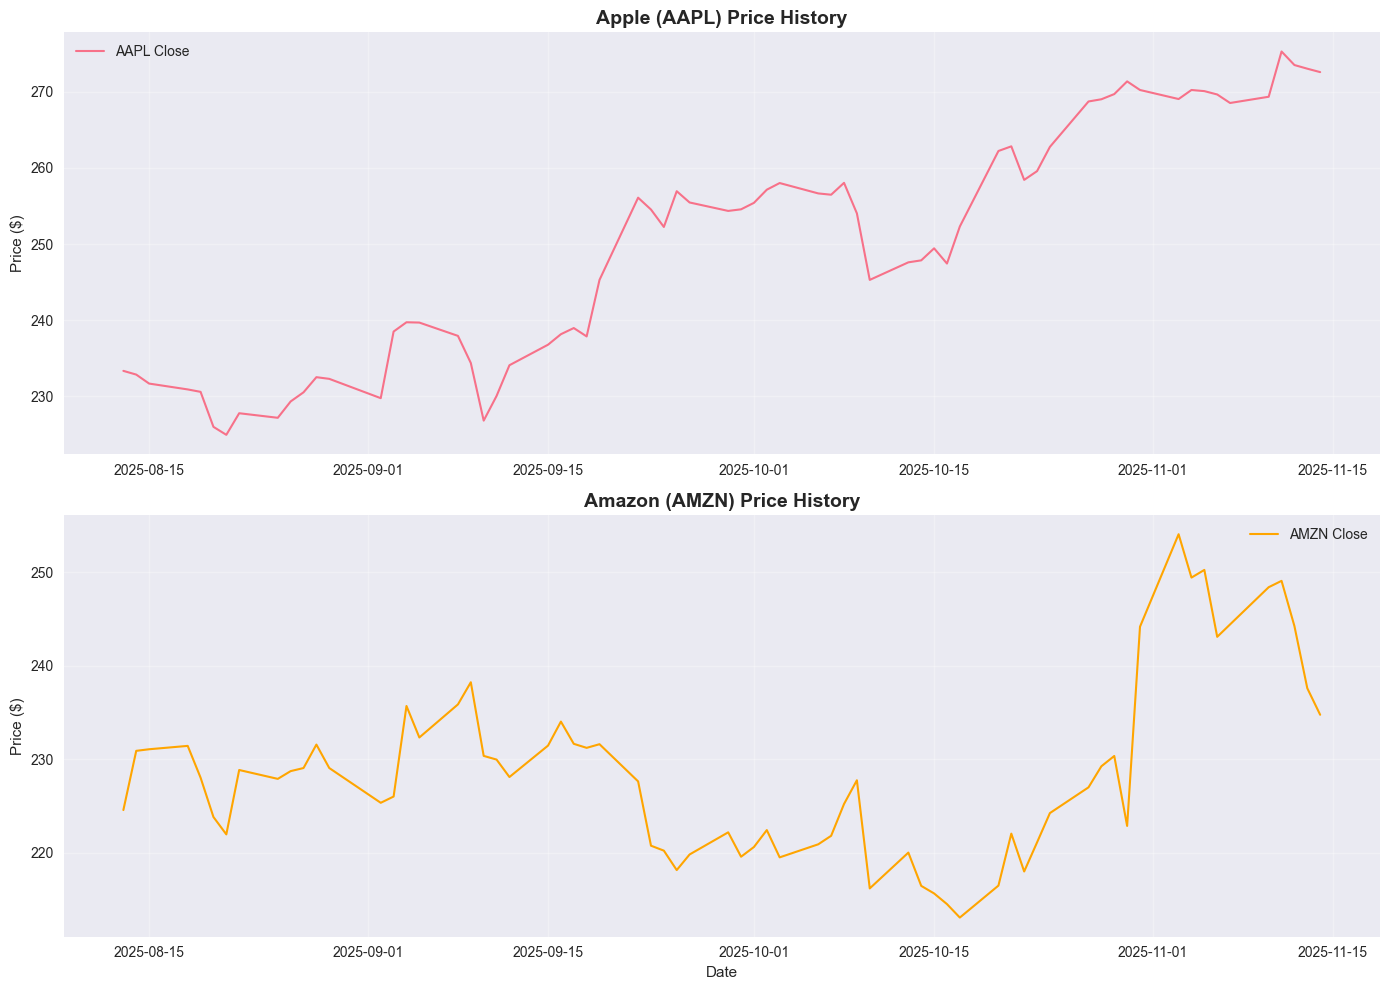

Price Statistics:
AAPL: $224.91 - $275.31
AMZN: $213.05 - $254.07


In [4]:
# Plot price history
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# AAPL prices
ax1.plot(aapl.index, aapl['close'], label='AAPL Close', linewidth=1.5)
ax1.set_title('Apple (AAPL) Price History', fontsize=14, fontweight='bold')
ax1.set_ylabel('Price ($)')
ax1.grid(True, alpha=0.3)
ax1.legend()

# AMZN prices
ax2.plot(amzn.index, amzn['close'], label='AMZN Close', color='orange', linewidth=1.5)
ax2.set_title('Amazon (AMZN) Price History', fontsize=14, fontweight='bold')
ax2.set_ylabel('Price ($)')
ax2.set_xlabel('Date')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Price statistics
print("Price Statistics:")
print(f"AAPL: ${aapl['close'].min():.2f} - ${aapl['close'].max():.2f}")
print(f"AMZN: ${amzn['close'].min():.2f} - ${amzn['close'].max():.2f}")

# 4. Returns: The Foundation of Quant Math
## 📉 From Prices to Returns

Let $P_t$ be the **closing price** at day $t$. We define two main notions of return.

### 4.1 Simple return

The **simple (or arithmetic) return** from day $t-1$ to $t$ is:
$$R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1.$$

Interpretation:
- $R_t = 0.02$ means a **+2%** daily move.
- $R_t = -0.03$ means a **−3%** daily move.

### 4.2 Log-return

The **log-return** from $t-1$ to $t$ is defined as:
$$r_t = \ln\left(\frac{P_t}{P_{t-1}}\right) = \ln(P_t) - \ln(P_{t-1}).$$

Key properties of log-returns:
1. **Additivity over time**
   If you go from $P_0$ to $P_1$ to $P_2$, then:
   $$r_{0\to2} = \ln\left(\frac{P_2}{P_0}\right) = \ln\left(\frac{P_1}{P_0}\right) + \ln\left(\frac{P_2}{P_1}\right) = r_{0\to1} + r_{1\to2}.$$
   This means **multi-period returns add** in log-space.

2. **Approximation for small moves**
   For small returns, $R_t \approx r_t$ (because $\ln(1+x) \approx x$ for small $x$).
   So log-returns are numerically close to simple returns for daily data.

3. **Symmetry and modeling**
   Log-returns tend to be more **symmetric** and more suitable for models that assume
   normally distributed increments (e.g. geometric Brownian motion).

From now on we mostly work with **log-returns** $r_t$.
They are the building block for volatility, Sharpe ratios, and risk models.

In the next cell, we compute and plot the daily log-returns for AAPL and AMZN.

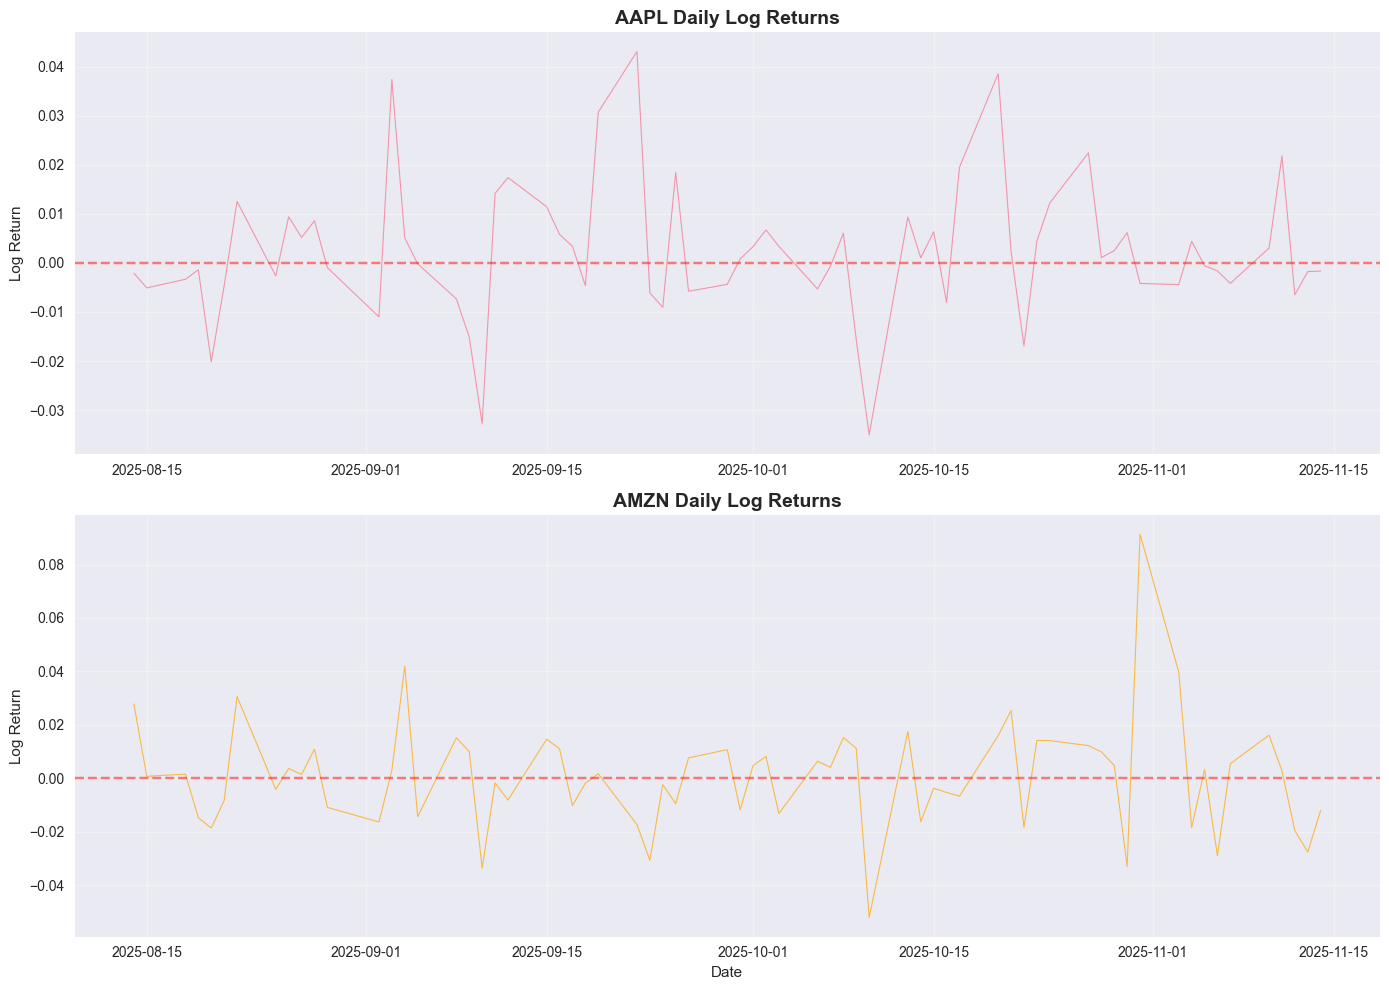

Returns computed successfully!
AAPL returns range: -0.0351 to 0.0431
AMZN returns range: -0.0521 to 0.0913


In [ ]:
# Compute log returns: add a column to the dataframe
#aapl['returns']
#amzn['returns']

# Remove first NaN


# Plot returns
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# AAPL returns
ax1.plot(aapl.index, aapl['returns'], alpha=0.7, linewidth=0.8)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax1.set_title('AAPL Daily Log Returns', fontsize=14, fontweight='bold')
ax1.set_ylabel('Log Return')
ax1.grid(True, alpha=0.3)

# AMZN returns
ax2.plot(amzn.index, amzn['returns'], alpha=0.7, linewidth=0.8, color='orange')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax2.set_title('AMZN Daily Log Returns', fontsize=14, fontweight='bold')
ax2.set_ylabel('Log Return')
ax2.set_xlabel('Date')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Returns computed successfully!")
print(f"AAPL returns range: {aapl['returns'].min():.4f} to {aapl['returns'].max():.4f}")
print(f"AMZN returns range: {amzn['returns'].min():.4f} to {amzn['returns'].max():.4f}")

# 5. Summary Statistics: Mean, Volatility, Sharpe, VaR
## 📊 Key Statistical Measures

Given a series of daily log-returns $r_1, r_2, \dots, r_T$, we now compute classical
risk–return statistics used everywhere in quant finance.

### 5.1 Sample mean (expected return)
The **sample mean** of daily returns is:
$$\bar{r} = \frac{1}{T} \sum_{t=1}^{T} r_t.$$

- Interpreted as the **average daily return**.
- Under some assumptions, $\bar{r}$ is an estimator of $E[r_t]$.

### 5.2 Sample volatility (standard deviation)
The **sample standard deviation** of daily returns is:
$$\sigma = \sqrt{\frac{1}{T-1} \sum_{t=1}^{T} (r_t - \bar{r})^2}.$$

- Interpreted as the **typical size of daily fluctuations**.
- It measures **risk** in the sense of variability (but not tail shape).

### 5.3 Annualisation
Assuming **independent and identically distributed** daily returns,
we often scale from daily to annual units:
$$\mu_{\text{ann}} = 252\, \bar{r}, \quad \sigma_{\text{ann}} = \sigma \sqrt{252}.$$

Here we use 252 trading days per year. The square-root rule for volatility comes from:
$$\text{Var}\left(\sum_{t=1}^n r_t\right) = n \cdot \text{Var}(r_t) \Rightarrow \sigma_{\text{n-day}} = \sqrt{n}\,\sigma.$$

### 5.4 Sharpe ratio (simplified)
The **Sharpe ratio** is a risk-adjusted performance measure:
$$\text{Sharpe} = \frac{\mu_{\text{ann}} - r_f}{\sigma_{\text{ann}}},$$
where $r_f$ is the annual risk-free rate.

In this educational notebook, we assume $r_f \approx 0$, so:
$$\text{Sharpe} \approx \frac{\mu_{\text{ann}}}{\sigma_{\text{ann}}}.$$

Interpretation:
- Sharpe $= 1$ means “1 unit of return per unit of risk”.
- Higher Sharpe is **better**, but it can be distorted by non-normal returns.

### 5.5 Value-at-Risk (VaR) under Normal Approximation

A basic version of **Value-at-Risk (VaR)** asks:
> “What loss level will we **not exceed** with probability $1-\alpha$ over one day?”

If we assume daily returns are **normally distributed** with mean $\mu$ and volatility $\sigma$,
then the $\alpha$-quantile of returns is:
$$q_\alpha = \mu + z_\alpha \sigma,$$
where $z_\alpha$ is the $\alpha$-quantile of a **standard** normal distribution.

For a 95% VaR (i.e. $\alpha = 0.05$):
- $z_{0.05} \approx -1.645$.
- A **loss** is a negative return, so we define
  $$\text{VaR}_{0.05} = -q_{0.05} = - (\mu + z_{0.05} \sigma).$$

This gives a **single number** summarizing the tail risk under a Gaussian assumption.
Later we will see that real returns are **not normal**, so this VaR is often overly optimistic.

### 📊 Kurtosis — Intuition & Formula

**Kurtosis** measures how prone a distribution is to produce *extreme values* — how heavy its tails are compared to a normal distribution.

---

#### 🔹 Definition

For a random variable $X$ with mean $\mu$ and standard deviation $\sigma$:

$$
\text{Kurtosis: } \beta_2 = \frac{\mathbb{E}[(X - \mu)^4]}{\sigma^4}
$$

The **excess kurtosis** (relative to the normal) is:

$$
\gamma_2 = \beta_2 - 3
$$

---

#### 🔹 Interpretation

- $\gamma_2 = 0$: Normal (mesokurtic)  
- $\gamma_2 > 0$: Heavy tails, more outliers (leptokurtic)  
- $\gamma_2 < 0$: Light tails, fewer outliers (platykurtic)

---

#### 🔹 Sample Estimate

For data $x_1, \dots, x_n$:

$$
g_2 = \frac{\frac{1}{n} \sum_{i=1}^n (x_i - \bar{x})^4}{\left( \frac{1}{n-1} \sum_{i=1}^n (x_i - \bar{x})^2 \right)^2}
$$

$$
\text{Excess kurtosis: } \hat{\gamma}_2 = g_2 - 3
$$

---

**Intuition:**  
Kurtosis amplifies large deviations (using the 4th power), so it grows quickly when extreme values occur.  
High kurtosis ⇒ “fat tails” and higher risk of outliers.


In [ ]:
def compute_risk_metrics(returns, name):
    """Compute comprehensive risk metrics for a series of daily log-returns.

    Returns a dictionary with string-formatted metrics for easy tabular display.
    """
    # Basic statistics: MEAN AND STD by hand(coded)
   # mean_daily =
    #vol_daily =

    # Annualized metrics
    mean_ann = mean_daily * 252
    vol_ann = vol_daily * np.sqrt(252)

    # Sharpe ratio (assuming 0 risk-free rate)
    sharpe = mean_ann / vol_ann if vol_ann > 0 else 0

    # VaR (Normal approximation)
    var_95 = -(mean_daily + stats.norm.ppf(0.05) * vol_daily)
    var_99 = -(mean_daily + stats.norm.ppf(0.01) * vol_daily)

    # Additional metrics
    skewness = returns.skew()
    kurtosis = returns.kurtosis()

    return {
        'Symbol': name,
        'Mean (Daily)': f"{mean_daily:.4f}",
        'Vol (Daily)': f"{vol_daily:.4f}",
        'Mean (Annual)': f"{mean_ann:.2%}",
        'Vol (Annual)': f"{vol_ann:.2%}",
        'Sharpe Ratio': f"{sharpe:.3f}",
        'VaR 95%': f"{var_95:.4f}",
        'VaR 99%': f"{var_99:.4f}",
        'Skewness': f"{skewness:.3f}",
        'Kurtosis': f"{kurtosis:.3f}"
    }

# Compute metrics for both stocks
aapl_metrics = compute_risk_metrics(aapl['returns'], 'AAPL')
amzn_metrics = compute_risk_metrics(amzn['returns'], 'AMZN')

# Create comparison table
metrics_df = pd.DataFrame([aapl_metrics, amzn_metrics])
print("Risk Metrics Comparison:")
print(metrics_df.to_string(index=False))

# Interpretation
print("\n📊 Key Insights:")
print(f"• Higher Sharpe: {'AAPL' if float(aapl_metrics['Sharpe Ratio']) > float(amzn_metrics['Sharpe Ratio']) else 'AMZN'}")
print(f"• Higher Volatility: {'AAPL' if float(aapl_metrics['Vol (Daily)']) > float(amzn_metrics['Vol (Daily)']) else 'AMZN'}")
print(f"• VaR tells us an estimate of the worst expected daily loss at 95% or 99% under a normality assumption.")

Risk Metrics Comparison:
Symbol Mean (Daily) Vol (Daily) Mean (Annual) Vol (Annual) Sharpe Ratio VaR 95% VaR 99% Skewness Kurtosis
  AAPL       0.0024      0.0140        59.41%       22.17%        2.679  0.0206  0.0301    0.456    1.914
  AMZN       0.0007      0.0208        16.95%       33.08%        0.512  0.0336  0.0478    1.054    4.818

📊 Key Insights:
• Higher Sharpe: AAPL
• Higher Volatility: AMZN
• VaR tells us an estimate of the worst expected daily loss at 95% or 99% under a normality assumption.


# 6. Rolling Windows: Moving Averages & Rolling Volatility
## 🔄 Rolling Statistics

Markets **change over time**. Using a single global mean and volatility for all years
often hides important regime shifts. To capture **local behaviour**, we use **rolling windows**.

### 6.1 Rolling mean
Given a price series $P_t$, the $N$-day rolling mean at time $t$ is:
$$\mu_t^{(N)} = \frac{1}{N} \sum_{i=0}^{N-1} P_{t-i}.$$

It approximates the **local average price** over the last $N$ days.

For returns $r_t$, we can similarly define a rolling mean:
$$\bar{r}_t^{(N)} = \frac{1}{N} \sum_{i=0}^{N-1} r_{t-i},$$
which leads to a **local annualized drift**:
$$\mu_{\text{ann}, t}^{(N)} \approx 252 \cdot \bar{r}_t^{(N)}.$$

### 6.2 Rolling volatility

The $N$-day rolling volatility of returns is:
$$\sigma_t^{(N)} = \sqrt{\frac{1}{N-1} \sum_{i=0}^{N-1} \bigl(r_{t-i} - \bar{r}_t^{(N)}\bigr)^2}.$$

We often annualize it as:
$$\sigma_{\text{ann}, t}^{(N)} = \sigma_t^{(N)} \sqrt{252}.$$

### 6.3 Interpreting rolling statistics

By plotting rolling mean and volatility, we see:
- **Volatility clustering**: high volatility tends to follow high volatility.
- **Regime changes**: certain periods look structurally riskier than others.
- **Local trends**: rolling means show periods of uptrend / downtrend.

In the next cell, students compute and plot 20-day and 60-day rolling volatility and mean.
The 20-day window reacts faster to new information; the 60-day smoother window gives a more
stable view of the underlying regime.

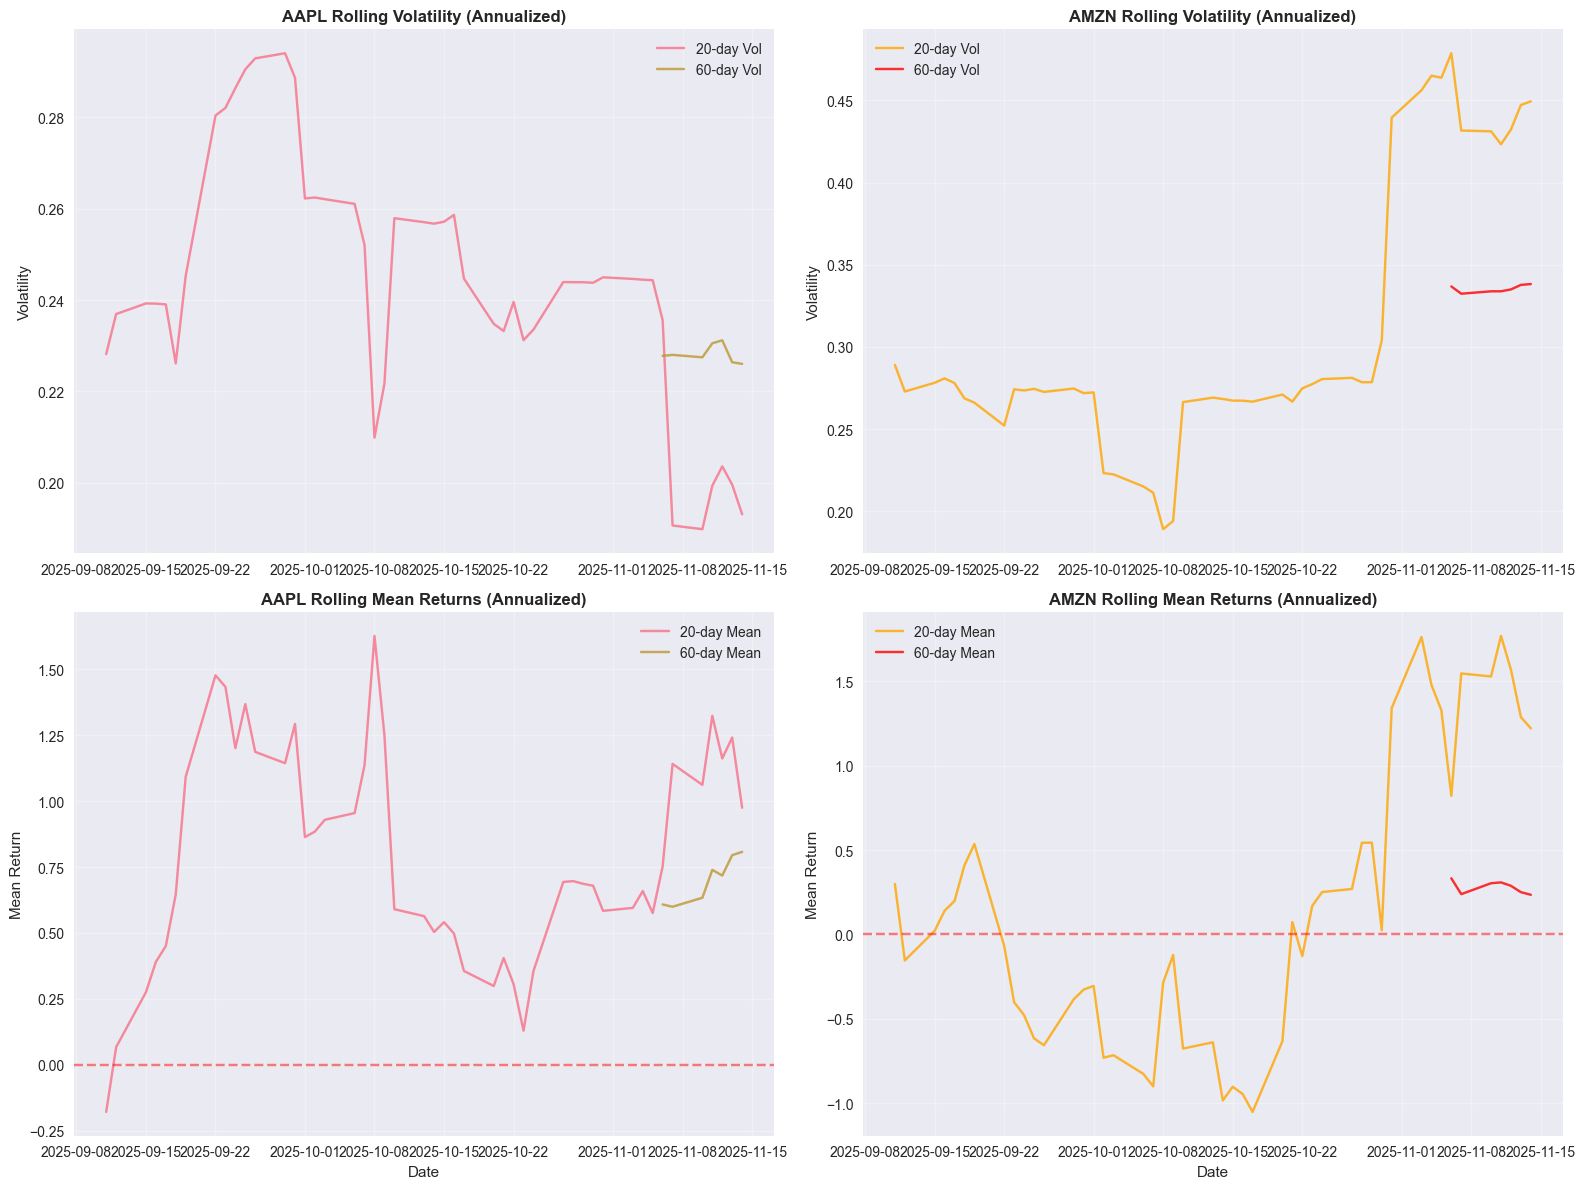

📈 Observations:
• Volatility clusters: high vol periods followed by high vol.
• 20-day window more reactive than 60-day (more noisy but faster).
• Rolling means highlight local momentum / trend changes.


In [17]:
# Compute rolling statistics
windows = [20, 60]

for window in windows:
    # Rolling volatility (annualized)
    aapl[f'vol_{window}d'] = aapl['returns'].rolling(window).std() * np.sqrt(252)
    amzn[f'vol_{window}d'] = amzn['returns'].rolling(window).std() * np.sqrt(252)

    # Rolling mean (annualized)
    aapl[f'mean_{window}d'] = aapl['returns'].rolling(window).mean() * 252
    amzn[f'mean_{window}d'] = amzn['returns'].rolling(window).mean() * 252

# Plot rolling volatility and rolling mean
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# AAPL volatility
ax1.plot(aapl.index, aapl['vol_20d'], label='20-day Vol', alpha=0.8)
ax1.plot(aapl.index, aapl['vol_60d'], label='60-day Vol', alpha=0.8)
ax1.set_title('AAPL Rolling Volatility (Annualized)', fontweight='bold')
ax1.set_ylabel('Volatility')
ax1.legend()
ax1.grid(True, alpha=0.3)

# AMZN volatility
ax2.plot(amzn.index, amzn['vol_20d'], label='20-day Vol', alpha=0.8, color='orange')
ax2.plot(amzn.index, amzn['vol_60d'], label='60-day Vol', alpha=0.8, color='red')
ax2.set_title('AMZN Rolling Volatility (Annualized)', fontweight='bold')
ax2.set_ylabel('Volatility')
ax2.legend()
ax2.grid(True, alpha=0.3)

# AAPL rolling returns
ax3.plot(aapl.index, aapl['mean_20d'], label='20-day Mean', alpha=0.8)
ax3.plot(aapl.index, aapl['mean_60d'], label='60-day Mean', alpha=0.8)
ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax3.set_title('AAPL Rolling Mean Returns (Annualized)', fontweight='bold')
ax3.set_ylabel('Mean Return')
ax3.set_xlabel('Date')
ax3.legend()
ax3.grid(True, alpha=0.3)

# AMZN rolling returns
ax4.plot(amzn.index, amzn['mean_20d'], label='20-day Mean', alpha=0.8, color='orange')
ax4.plot(amzn.index, amzn['mean_60d'], label='60-day Mean', alpha=0.8, color='red')
ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax4.set_title('AMZN Rolling Mean Returns (Annualized)', fontweight='bold')
ax4.set_ylabel('Mean Return')
ax4.set_xlabel('Date')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📈 Observations:")
print("• Volatility clusters: high vol periods followed by high vol.")
print("• 20-day window more reactive than 60-day (more noisy but faster).")
print("• Rolling means highlight local momentum / trend changes.")

# 7. Return Distributions & Normality
## 📦 Are Returns Normal? (Spoiler: No)

Many classical models (e.g. Black–Scholes) assume that returns are **normally distributed**.
We now test this assumption empirically for our daily log-returns.

### 7.1 What do we look at?
- **Histograms** of returns vs. fitted normal density.
- **Q-Q plots** (quantile–quantile plots) comparing empirical quantiles to normal quantiles.
- **Skewness** (asymmetry of the distribution).
- **Kurtosis** (fatness of tails; excess kurtosis measures how much heavier tails are vs. normal).
- **Jarque–Bera test** and **Shapiro–Wilk test** for normality.

### 7.2 Stylized facts of financial returns
Real market returns typically exhibit:
- **Fat tails**: extreme events happen more often than a normal distribution predicts.
- **Skewness**: distributions are often not symmetric (e.g. more large negative moves).
- **Volatility clustering**: large moves tend to cluster in time.
- **Leverage effects**: volatility may increase after negative shocks.

These properties **violate normality** and matter for risk management.
For example, VaR under normality underestimates the probability of large crashes.

In the next cell, we formally test normality for AAPL and AMZN returns and interpret the results.

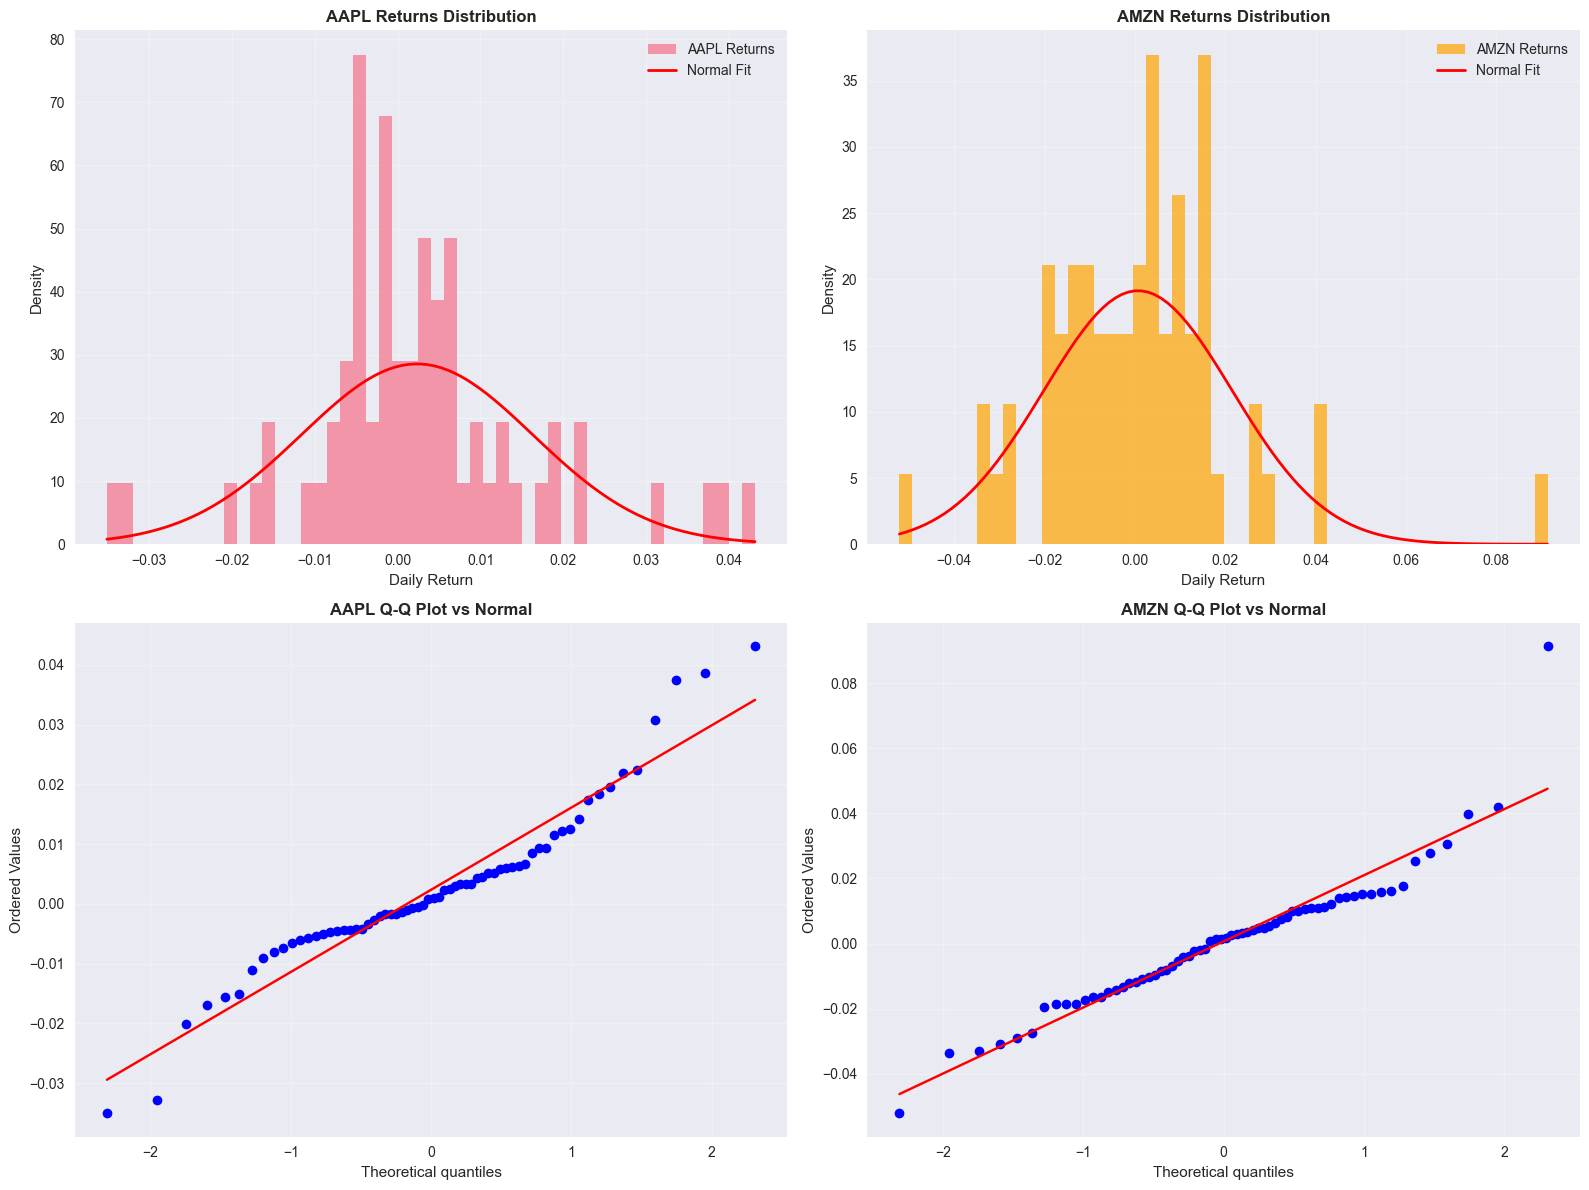


AAPL Normality Tests:
Skewness: 0.4563
Kurtosis: 1.9139 (excess kurtosis)
Jarque-Bera: stat=9.9710, p-value=0.006836
Shapiro-Wilk: stat=0.9383, p-value=0.002641
❌ Reject normality (p < 0.05)

AMZN Normality Tests:
Skewness: 1.0540
Kurtosis: 4.8176 (excess kurtosis)
Jarque-Bera: stat=64.2016, p-value=0.000000
Shapiro-Wilk: stat=0.9261, p-value=0.000736
❌ Reject normality (p < 0.05)

🔍 Key Findings:
• Fat tails: More extreme events than normal distribution predicts.
• Excess kurtosis: Returns are more peaked and heavy-tailed.
• Normality-based risk measures (like Gaussian VaR) are over-optimistic.


In [18]:
# Distribution analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# AAPL histogram
ax1.hist(aapl['returns'], bins=50, alpha=0.7, density=True, label='AAPL Returns')
# Overlay normal distribution
x = np.linspace(aapl['returns'].min(), aapl['returns'].max(), 100)
normal_pdf = stats.norm.pdf(x, aapl['returns'].mean(), aapl['returns'].std())
ax1.plot(x, normal_pdf, 'r-', label='Normal Fit', linewidth=2)
ax1.set_title('AAPL Returns Distribution', fontweight='bold')
ax1.set_xlabel('Daily Return')
ax1.set_ylabel('Density')
ax1.legend()
ax1.grid(True, alpha=0.3)

# AMZN histogram
ax2.hist(amzn['returns'], bins=50, alpha=0.7, density=True, label='AMZN Returns', color='orange')
x = np.linspace(amzn['returns'].min(), amzn['returns'].max(), 100)
normal_pdf = stats.norm.pdf(x, amzn['returns'].mean(), amzn['returns'].std())
ax2.plot(x, normal_pdf, 'r-', label='Normal Fit', linewidth=2)
ax2.set_title('AMZN Returns Distribution', fontweight='bold')
ax2.set_xlabel('Daily Return')
ax2.set_ylabel('Density')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Q-Q plots
stats.probplot(aapl['returns'], dist="norm", plot=ax3)
ax3.set_title('AAPL Q-Q Plot vs Normal', fontweight='bold')
ax3.grid(True, alpha=0.3)

stats.probplot(amzn['returns'], dist="norm", plot=ax4)
ax4.set_title('AMZN Q-Q Plot vs Normal', fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Normality tests
def test_normality(returns, name):
    """Perform normality tests and print diagnostic statistics."""
    # Jarque-Bera test (sensitive to skewness and kurtosis)
    jb_stat, jb_pvalue = stats.jarque_bera(returns)

    # Shapiro-Wilk test (for smaller samples)
    if len(returns) <= 5000:
        sw_stat, sw_pvalue = stats.shapiro(returns)
    else:
        sw_stat, sw_pvalue = None, None

    print(f"\n{name} Normality Tests:")
    print(f"Skewness: {returns.skew():.4f}")
    print(f"Kurtosis: {returns.kurtosis():.4f} (excess kurtosis)")
    print(f"Jarque-Bera: stat={jb_stat:.4f}, p-value={jb_pvalue:.6f}")
    if sw_stat is not None:
        print(f"Shapiro-Wilk: stat={sw_stat:.4f}, p-value={sw_pvalue:.6f}")

    # Interpretation
    if jb_pvalue < 0.05:
        print("❌ Reject normality (p < 0.05)")
    else:
        print("✅ Cannot reject normality (p >= 0.05)")

test_normality(aapl['returns'], 'AAPL')
test_normality(amzn['returns'], 'AMZN')

print("\n🔍 Key Findings:")
print("• Fat tails: More extreme events than normal distribution predicts.")
print("• Excess kurtosis: Returns are more peaked and heavy-tailed.")
print("• Normality-based risk measures (like Gaussian VaR) are over-optimistic.")

# 8. Co-Movement: Correlation
## 🔗 Relationship Between AAPL & AMZN

We now study **how AAPL and AMZN move together**.
The main tool here is **correlation**.

### 8.1 Correlation of returns

Let $X$ be the returns of AAPL and $Y$ the returns of AMZN.
The covariance is:
$$\text{Cov}(X, Y) = E[(X - E[X])(Y - E[Y])].$$

The **correlation coefficient** is the covariance normalized by the standard deviations:
$$\rho_{XY} = \frac{\text{Cov}(X, Y)}{\sigma_X \sigma_Y}.$$

Properties:
- $\rho_{XY} \in [-1, 1]$.
- $\rho_{XY} \approx 1$: strong positive linear relationship.
- $\rho_{XY} \approx -1$: strong negative linear relationship.
- $\rho_{XY} \approx 0$: weak linear relationship.

### 8.2 Time-varying correlation

Correlation is **not constant** over time.
We therefore compute:
- A **full-period correlation** (one number).
- A **rolling 60-day correlation** to see how it evolves.

### 8.3 Visual tools
- **Scatter plot** of AAPL vs AMZN returns, with a regression line.
- **Rolling correlation plot** to see clustering/regime shifts.
- **Histogram** of rolling correlations.

These will motivate constructing a **spread** between the two stocks in the next section.

Try to calculate a simple correlation coding yourself. use the test_corr below. Each column represents a feature, and rows observations

In [ ]:
test_corr = np.random.rand((3,3))

Common trading days: 66


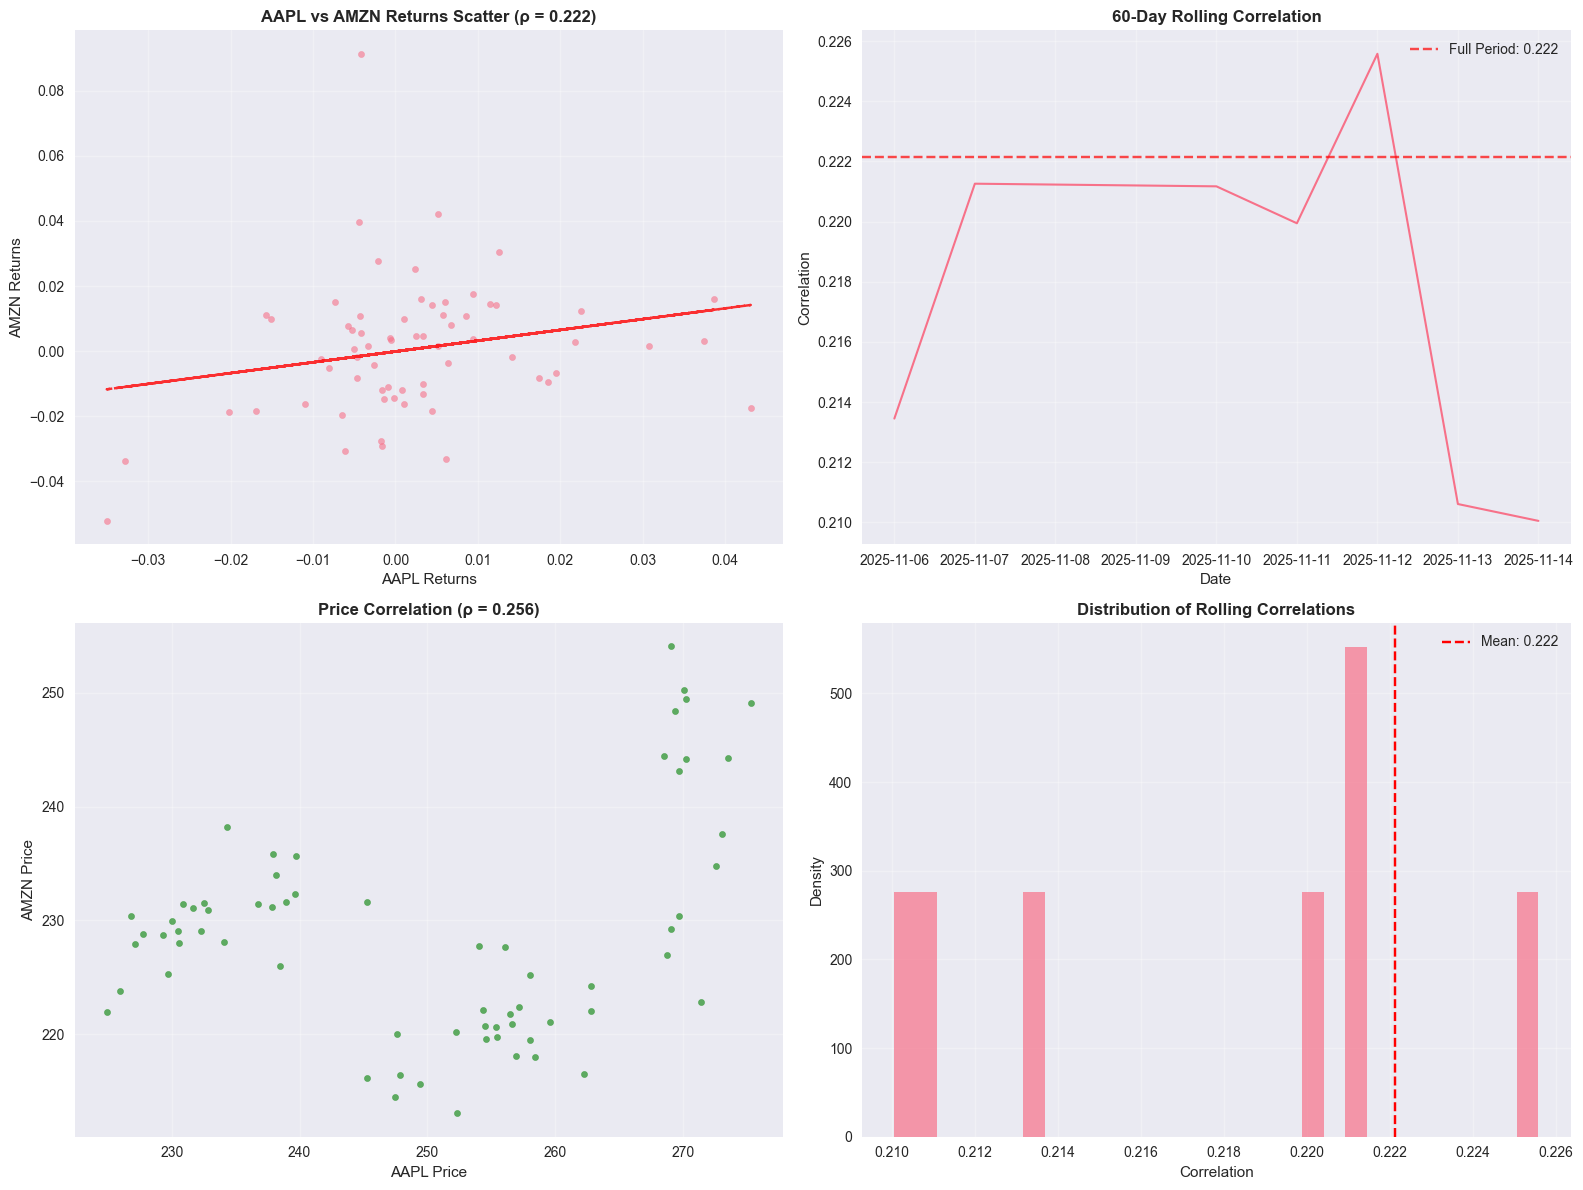


📊 Correlation Analysis:
Full-period correlation: 0.2221
Rolling correlation mean: 0.2174
Rolling correlation std: 0.0060
Rolling correlation range: 0.2101 to 0.2256

🔍 Insights:
• Weak correlation - limited co-movement.
• Correlation is time-varying - this creates potential opportunities for relative-value / spread trading.


In [19]:
# Align data by common dates
common_dates = aapl.index.intersection(amzn.index)
aapl_aligned = aapl.loc[common_dates]
amzn_aligned = amzn.loc[common_dates]

print(f"Common trading days: {len(common_dates)}")

# Compute correlations
full_corr = aapl_aligned['returns'].corr(amzn_aligned['returns'])
rolling_corr = aapl_aligned['returns'].rolling(60).corr(amzn_aligned['returns'])

# Create correlation plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Scatter plot
ax1.scatter(aapl_aligned['returns'], amzn_aligned['returns'], alpha=0.6, s=20)
ax1.set_xlabel('AAPL Returns')
ax1.set_ylabel('AMZN Returns')
ax1.set_title(f'AAPL vs AMZN Returns Scatter (ρ = {full_corr:.3f})', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add regression line
z = np.polyfit(aapl_aligned['returns'], amzn_aligned['returns'], 1)
p = np.poly1d(z)
ax1.plot(aapl_aligned['returns'], p(aapl_aligned['returns']), "r--", alpha=0.8)

# Rolling correlation
ax2.plot(common_dates, rolling_corr, linewidth=1.5)
ax2.axhline(y=full_corr, color='red', linestyle='--', alpha=0.7, label=f'Full Period: {full_corr:.3f}')
ax2.set_title('60-Day Rolling Correlation', fontweight='bold')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Date')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Price correlation (for comparison)
price_corr = aapl_aligned['close'].corr(amzn_aligned['close'])
ax3.scatter(aapl_aligned['close'], amzn_aligned['close'], alpha=0.6, s=20, color='green')
ax3.set_xlabel('AAPL Price')
ax3.set_ylabel('AMZN Price')
ax3.set_title(f'Price Correlation (ρ = {price_corr:.3f})', fontweight='bold')
ax3.grid(True, alpha=0.3)

# Correlation distribution
ax4.hist(rolling_corr.dropna(), bins=30, alpha=0.7, density=True)
ax4.axvline(x=full_corr, color='red', linestyle='--', label=f'Mean: {full_corr:.3f}')
ax4.set_title('Distribution of Rolling Correlations', fontweight='bold')
ax4.set_xlabel('Correlation')
ax4.set_ylabel('Density')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation statistics
print(f"\n📊 Correlation Analysis:")
print(f"Full-period correlation: {full_corr:.4f}")
print(f"Rolling correlation mean: {rolling_corr.mean():.4f}")
print(f"Rolling correlation std: {rolling_corr.std():.4f}")
print(f"Rolling correlation range: {rolling_corr.min():.4f} to {rolling_corr.max():.4f}")

print(f"\n🔍 Insights:")
if full_corr > 0.5:
    print("• Strong positive correlation - both stocks tend to move together.")
elif full_corr > 0.3:
    print("• Moderate positive correlation - some co-movement.")
else:
    print("• Weak correlation - limited co-movement.")

print("• Correlation is time-varying - this creates potential opportunities for relative-value / spread trading.")

# 9. Constructing a Spread & Z-Score (No Cointegration Yet)
## 📏 Building a Basic Spread

We now construct a **simple spread** between AAPL and AMZN based on their **normalized prices**.
This is a toy example **without** formal cointegration testing.

### 9.1 Normalizing prices
For stock $i$ (AAPL or AMZN), we define a normalized price:
$$\tilde{P}_t^{(i)} = \frac{P_t^{(i)}}{P_0^{(i)}},$$
so that:
- $\tilde{P}_0^{(i)} = 1$ at the start,
- and $\tilde{P}_t^{(i)}$ shows **cumulative performance** since the start.

This puts both stocks on a **comparable scale**, regardless of their absolute price levels.

### 9.2 Defining the spread
We define the spread at time $t$ as:
$$s_t = \tilde{P}_t^{(\text{AAPL})} - \tilde{P}_t^{(\text{AMZN})}.$$

- If $s_t$ is **positive and large**, AAPL has outperformed AMZN.
- If $s_t$ is **negative and large in magnitude**, AMZN has outperformed AAPL.

### 9.3 Z-score of the spread
We compute the **mean** and **standard deviation** of the spread over the full sample:
$$\mu_s = E[s_t], \quad \sigma_s = \sqrt{E[(s_t - \mu_s)^2]}.$$

The **z-score** of the spread is then:
$$Z_t = \frac{s_t - \mu_s}{\sigma_s}.$$

Interpretation:
- $Z_t \approx 0$: spread is near its historical average.
- $Z_t > 2$: spread is **2 standard deviations above** its mean (AAPL strongly outperformed AMZN).
- $Z_t < -2$: spread is **2 standard deviations below** its mean (AMZN strongly outperformed AAPL).

In classic **pairs trading**, large $|Z_t|$ values are interpreted as **unusual deviations** that may mean-revert.
Here we use this idea to build an educational mean-reversion strategy later on.

Important caveat: 
- This construction **does not check** for cointegration.
- We are implicitly assuming some mean-reversion that may **not** hold in reality.
Later, we will use tests to show why this can be dangerous.

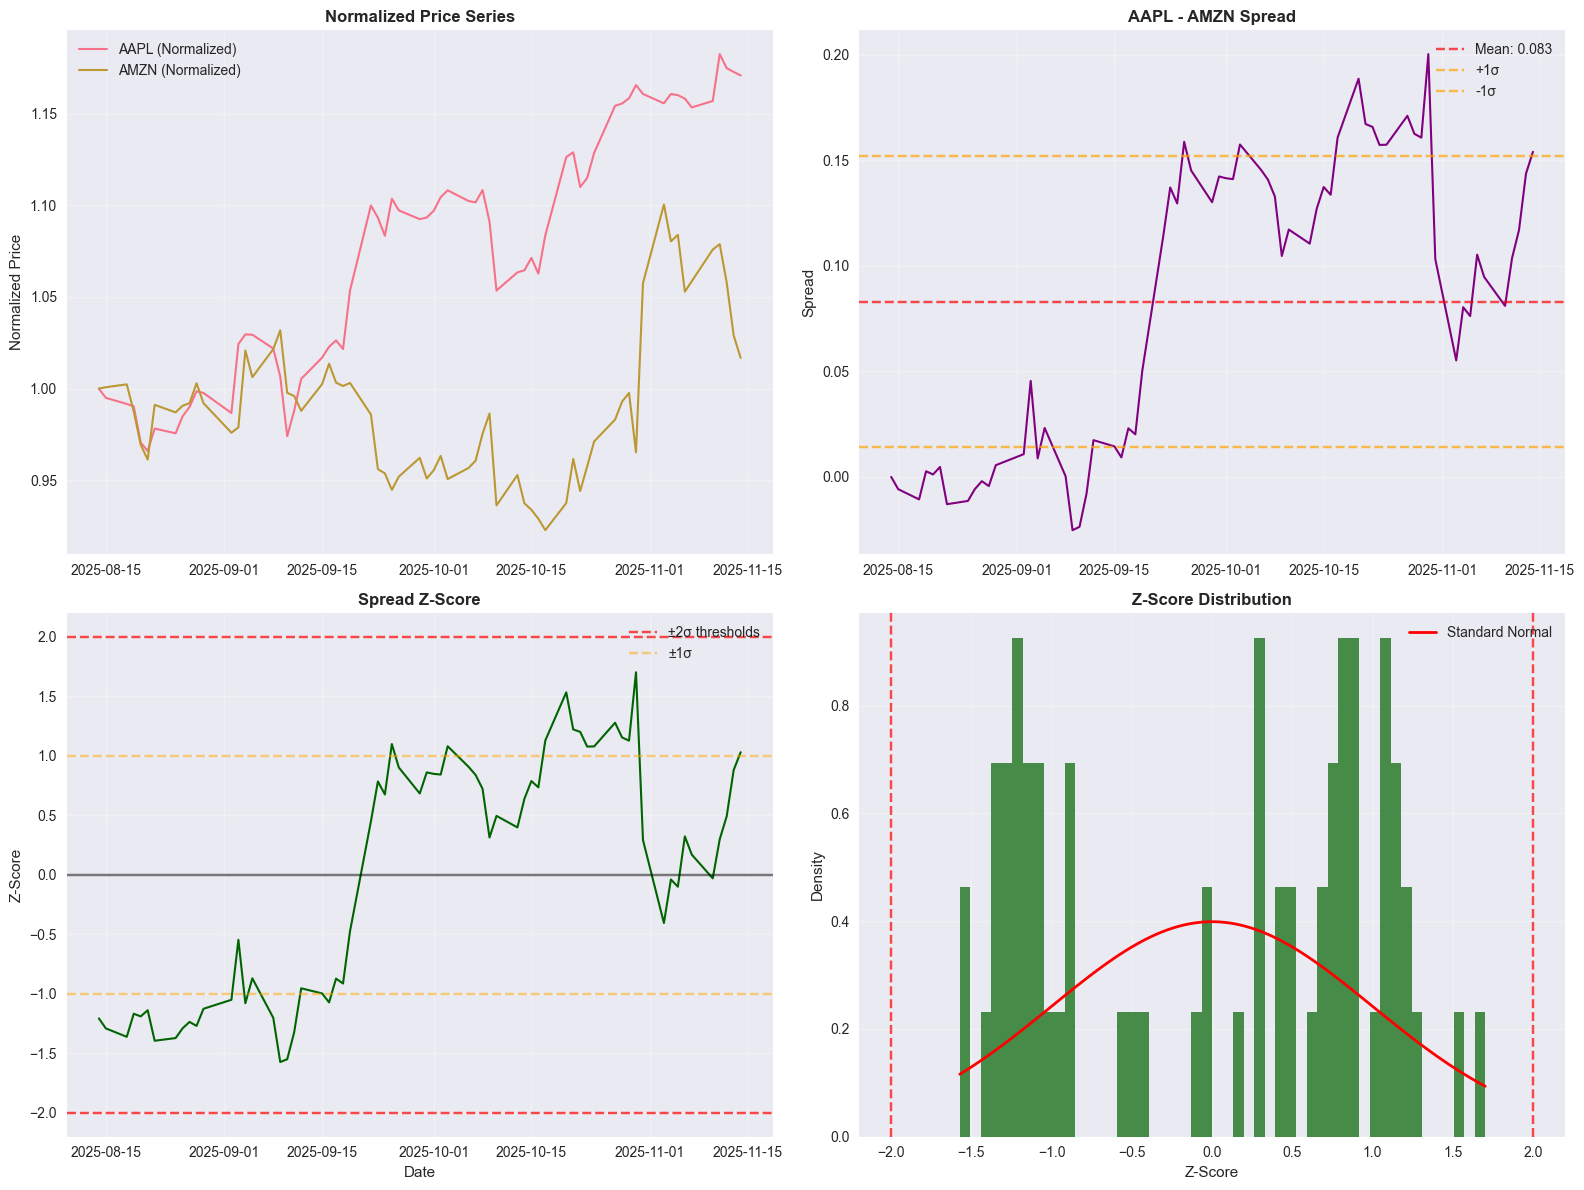

📊 Spread Statistics:
Spread mean: 0.0831
Spread std: 0.0689
Z-score mean: 0.0000
Z-score std: 1.0000
Z-score range: -1.57 to 1.70

🎯 Trading Signals:
Days with |Z| > 2: 0 (0.0%)
Days with Z > 2: 0 (short spread signals)
Days with Z < -2: 0 (long spread signals)

Spread data prepared for strategy backtesting!


In [ ]:
# Normalize prices to start at 1


# Construct spread


# Compute z-score


# Plot spread analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Normalized prices
ax1.plot(common_dates, aapl_norm, label='AAPL (Normalized)', linewidth=1.5)
ax1.plot(common_dates, amzn_norm, label='AMZN (Normalized)', linewidth=1.5)
ax1.set_title('Normalized Price Series', fontweight='bold')
ax1.set_ylabel('Normalized Price')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Raw spread
ax2.plot(common_dates, spread, linewidth=1.5, color='purple')
ax2.axhline(y=spread_mean, color='red', linestyle='--', alpha=0.7, label=f'Mean: {spread_mean:.3f}')
ax2.axhline(y=spread_mean + spread_std, color='orange', linestyle='--', alpha=0.7, label='+1σ')
ax2.axhline(y=spread_mean - spread_std, color='orange', linestyle='--', alpha=0.7, label='-1σ')
ax2.set_title('AAPL - AMZN Spread', fontweight='bold')
ax2.set_ylabel('Spread')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Z-score
ax3.plot(common_dates, z_score, linewidth=1.5, color='darkgreen')
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax3.axhline(y=2, color='red', linestyle='--', alpha=0.7, label='±2σ thresholds')
ax3.axhline(y=-2, color='red', linestyle='--', alpha=0.7)
ax3.axhline(y=1, color='orange', linestyle='--', alpha=0.5, label='±1σ')
ax3.axhline(y=-1, color='orange', linestyle='--', alpha=0.5)
ax3.set_title('Spread Z-Score', fontweight='bold')
ax3.set_ylabel('Z-Score')
ax3.set_xlabel('Date')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Z-score distribution
ax4.hist(z_score, bins=50, alpha=0.7, density=True, color='darkgreen')
# Overlay standard normal
x = np.linspace(z_score.min(), z_score.max(), 100)
normal_pdf = stats.norm.pdf(x, 0, 1)
ax4.plot(x, normal_pdf, 'r-', label='Standard Normal', linewidth=2)
ax4.axvline(x=2, color='red', linestyle='--', alpha=0.7)
ax4.axvline(x=-2, color='red', linestyle='--', alpha=0.7)
ax4.set_title('Z-Score Distribution', fontweight='bold')
ax4.set_xlabel('Z-Score')
ax4.set_ylabel('Density')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Spread statistics
print(f"📊 Spread Statistics:")
print(f"Spread mean: {spread_mean:.4f}")
print(f"Spread std: {spread_std:.4f}")
print(f"Z-score mean: {z_score.mean():.4f}")
print(f"Z-score std: {z_score.std():.4f}")
print(f"Z-score range: {z_score.min():.2f} to {z_score.max():.2f}")

# Extreme events
extreme_high = (z_score > 2).sum()
extreme_low = (z_score < -2).sum()
total_days = len(z_score)

print(f"\n🎯 Trading Signals:")
print(f"Days with |Z| > 2: {extreme_high + extreme_low} ({100*(extreme_high + extreme_low)/total_days:.1f}%)")
print(f"Days with Z > 2: {extreme_high} (short spread signals)")
print(f"Days with Z < -2: {extreme_low} (long spread signals)")

# Store for strategy
spread_data = pd.DataFrame({
    'aapl_norm': aapl_norm,
    'amzn_norm': amzn_norm,
    'spread': spread,
    'z_score': z_score,
    'aapl_close': aapl_aligned['close'],
    'amzn_close': amzn_aligned['close'],
    'aapl_open': aapl_aligned['open'],
    'amzn_open': amzn_aligned['open']
}, index=common_dates)

print(f"\nSpread data prepared for strategy backtesting!")

# 10. Execution Timing, Signal Decay, Gap Risk, Slippage
## 🕒 The Reality of Execution

So far, we have treated prices and signals **mathematically** without worrying about
how trades actually get executed. Here we add the next layer of realism.
### 10.1 Signal computed at Close
At day $t$, we compute the spread z-score using the **closing prices**:
$$Z_t = f(C_t^{\text{AAPL}}, C_t^{\text{AMZN}}).$$

### 10.2 Execution at the next Open
However, we can only trade at the **next day's Open**:
$$\text{signal}_t \Rightarrow \text{trade at Open}_{t+1}.$$

This delay introduces:
- **Gap risk**:
  $$\text{gap}_t^{(i)} = \text{Open}_{t+1}^{(i)} - \text{Close}_t^{(i)}.$$
  For each stock $i$, the price can jump overnight.
- **Signal decay**:
  The z-score based on opens on day $t+1$ may differ significantly from the close-based z-score.

### 10.3 Signal confirmation
To model this, we recompute a z-score using **open prices**:
$$Z_{t+1}^{(\text{open})} = f(O_{t+1}^{\text{AAPL}}, O_{t+1}^{\text{AMZN}}),$$
and only trade if the signal is still sufficiently strong.

### 10.4 Slippage model
In real markets, you rarely trade exactly at the mid or official Open.
We use a simple slippage model:
- **Buying:**
  $$\text{price} = \text{Open}_{t+1} (1 + s),$$
- **Selling:**
  $$\text{price} = \text{Open}_{t+1} (1 - s),$$
with a small slippage parameter $s \approx 0.05\%$.

This introduces:
- **Execution costs** proportional to trade size.
- **Microstructure effects** that eat into theoretical PnL.

In the next cell, we quantify:
- how big overnight gaps are,
- how often signals decay between Close and next Open,
- and how persistent signals really are.

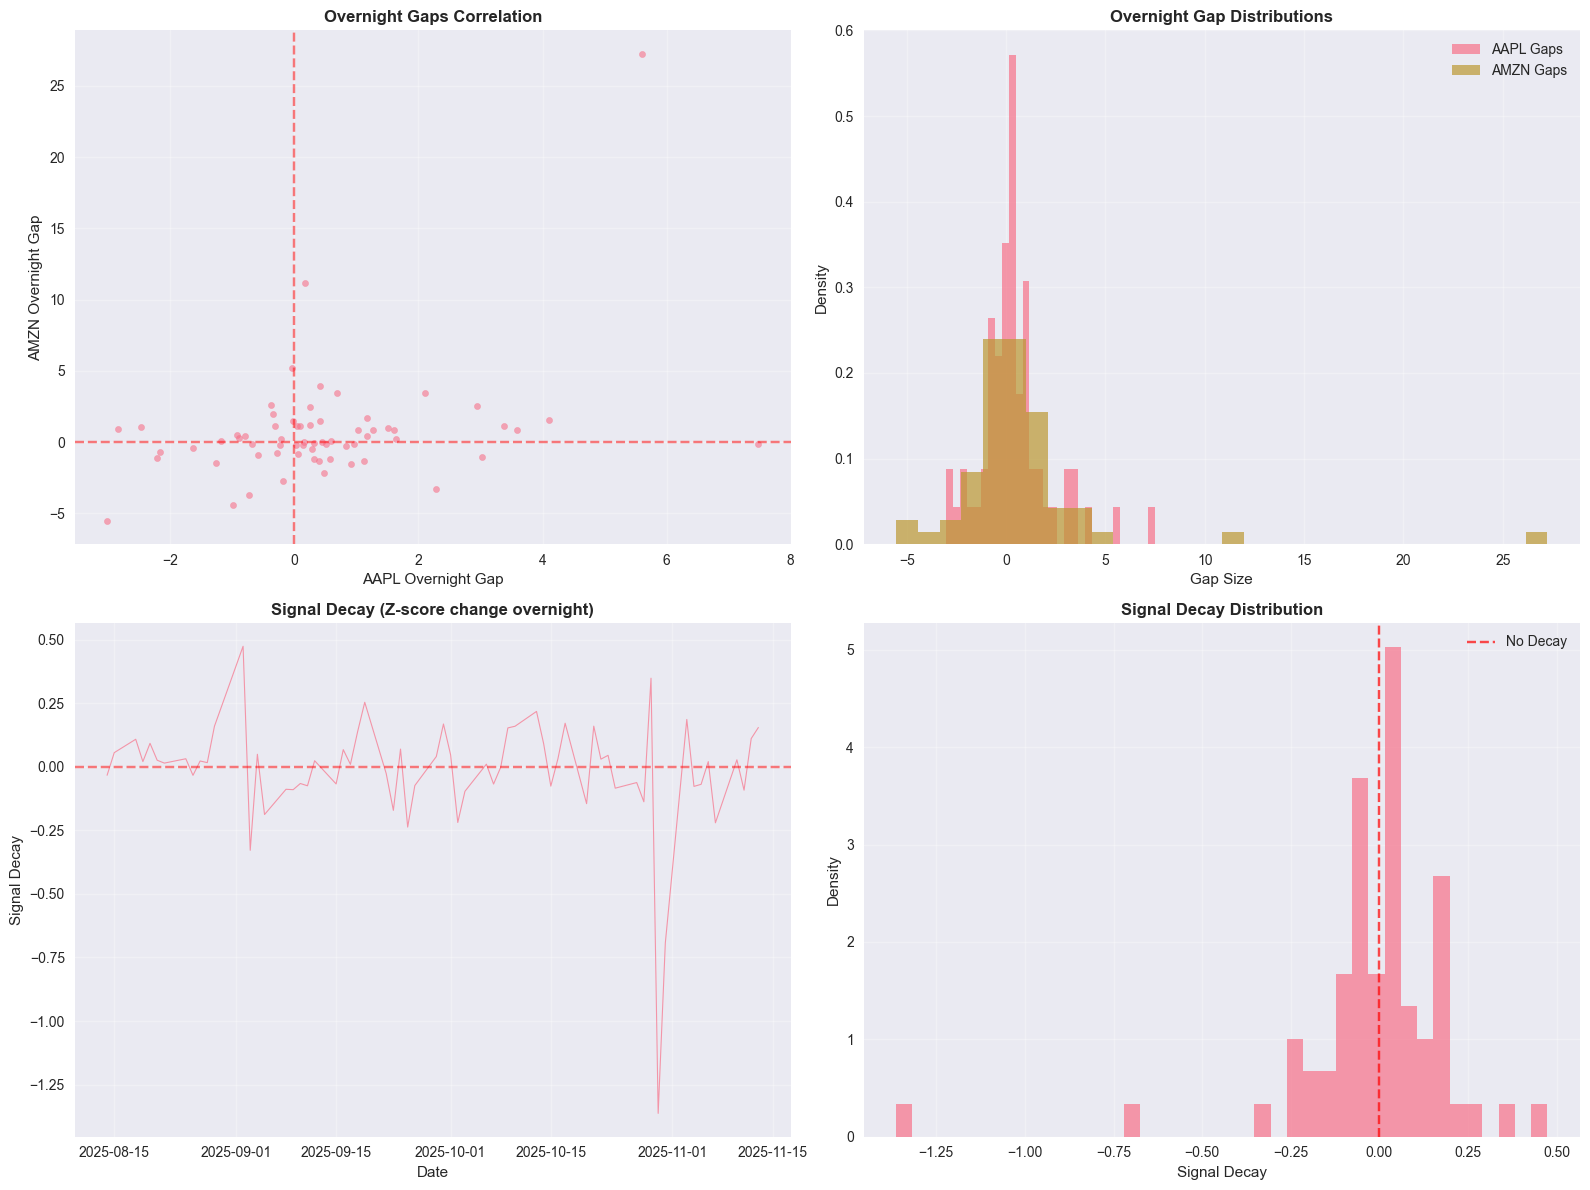

📊 Execution Timing Analysis:

Gap Statistics:
AAPL gap mean: 0.4593, std: 1.7916
AMZN gap mean: 0.7194, std: 4.0488
Gap correlation: 0.3875

Signal Decay:
Mean signal decay: -0.0166
Signal decay std: 0.2350
Signal persistence rate: 75.00%

⚠️ Key Risks:
• Overnight gaps can destroy signal profitability.
• Only 75% of strong signals persist to next day.
• Signal decay adds execution uncertainty.


In [ ]:
# Analyze execution timing effects
def compute_gaps_and_decay(data):
    """Compute gap risk and signal decay metrics.

    - Gaps: next-day open minus previous close for each stock.
    - Open-based z-score: recomputed from open-normalized prices.
    - Signal decay: change in z-score from close-based to next open-based.
    """
    # Compute gaps for both stocks
    aapl_gaps = data['aapl_open'].shift(-1) - data['aapl_close']
    amzn_gaps = data['amzn_open'].shift(-1) - data['amzn_close']

    # Compute next-day z-score using open prices (normalized similarly to close-based)
    #aapl_norm_open
    #amzn_norm_open
    #spread_open
    #z_score_open

    # Signal decay: difference between close and next open z-scores
    signal_decay = z_score_open.shift(-1) - data['z_score']

    return aapl_gaps, amzn_gaps, z_score_open, signal_decay

aapl_gaps, amzn_gaps, z_score_open, signal_decay = compute_gaps_and_decay(spread_data)

# Plot execution timing analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Gap analysis
ax1.scatter(aapl_gaps, amzn_gaps, alpha=0.6, s=20)
ax1.set_xlabel('AAPL Overnight Gap')
ax1.set_ylabel('AMZN Overnight Gap')
ax1.set_title('Overnight Gaps Correlation', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.5)

# Gap distribution
ax2.hist(aapl_gaps.dropna(), bins=30, alpha=0.7, label='AAPL Gaps', density=True)
ax2.hist(amzn_gaps.dropna(), bins=30, alpha=0.7, label='AMZN Gaps', density=True)
ax2.set_title('Overnight Gap Distributions', fontweight='bold')
ax2.set_xlabel('Gap Size')
ax2.set_ylabel('Density')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Signal decay
ax3.plot(spread_data.index, signal_decay, alpha=0.7, linewidth=0.8)
ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax3.set_title('Signal Decay (Z-score change overnight)', fontweight='bold')
ax3.set_ylabel('Signal Decay')
ax3.set_xlabel('Date')
ax3.grid(True, alpha=0.3)

# Signal persistence
# Check how often signals persist overnight
strong_signals = np.abs(spread_data['z_score']) > 1.5
next_day_strong = np.abs(z_score_open.shift(-1)) > 1.0  # Slightly relaxed threshold
signal_persistence = strong_signals & next_day_strong

persistence_rate = signal_persistence.sum() / strong_signals.sum() if strong_signals.sum() > 0 else 0

ax4.hist(signal_decay.dropna(), bins=40, alpha=0.7, density=True)
ax4.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='No Decay')
ax4.set_title('Signal Decay Distribution', fontweight='bold')
ax4.set_xlabel('Signal Decay')
ax4.set_ylabel('Density')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Execution statistics
print(f"📊 Execution Timing Analysis:")
print(f"\nGap Statistics:")
print(f"AAPL gap mean: {aapl_gaps.mean():.4f}, std: {aapl_gaps.std():.4f}")
print(f"AMZN gap mean: {amzn_gaps.mean():.4f}, std: {amzn_gaps.std():.4f}")
print(f"Gap correlation: {aapl_gaps.corr(amzn_gaps):.4f}")

print(f"\nSignal Decay:")
print(f"Mean signal decay: {signal_decay.mean():.4f}")
print(f"Signal decay std: {signal_decay.std():.4f}")
print(f"Signal persistence rate: {persistence_rate:.2%}")

print(f"\n⚠️ Key Risks:")
print(f"• Overnight gaps can destroy signal profitability.")
print(f"• Only {persistence_rate:.0%} of strong signals persist to next day.")
print(f"• Signal decay adds execution uncertainty.")

# Store execution data
spread_data['aapl_gaps'] = aapl_gaps
spread_data['amzn_gaps'] = amzn_gaps
spread_data['z_score_open'] = z_score_open
spread_data['signal_decay'] = signal_decay

# 11. Simple Mean-Reversion Strategy
## 📉 The Strategy

We are now ready to define a simple **mean-reversion** strategy on the spread.  
This model is for **educational purposes** and is intentionally **naive** — it demonstrates the logic before adding real-world complexity.

---

### 11.1 Entry rules

We use the close-based z-score $Z_t$ to detect when the spread is "too far" from its mean:

- If $Z_t > 2$: the spread is **rich** (AAPL too strong vs AMZN) → **short** the spread.  
- If $Z_t < -2$: the spread is **cheap** (AAPL too weak vs AMZN) → **long** the spread.

In practice, “short spread” means:
- short AAPL (or underweight it),
- long AMZN (or overweight it),
in some approximately **dollar-neutral** ratio.  
We abstract away exact hedge ratios here — the focus is on signal logic.

---

### 11.2 Confirmation at next Open

Because we can only trade at $t+1$, we confirm the signal using the **open-based z-score** $Z^{(\text{open})}_{t+1}$:

- If the spread has already reverted overnight, we **cancel** the trade.  
- This prevents acting on stale signals that disappeared between Close and Open.

---

### 11.3 Exit rule

We exit (flatten the position) when the spread has mostly reverted toward its mean:

- If we hold any position and $|Z_t| < 0.5$, we **close the trade**.  

This creates a **two-threshold system**:
- Wide deviations → enter trade.  
- Small deviations → exit and lock in profit (or cut loss).

---

### 11.4 PnL approximation

We model the daily strategy return (PnL increment) with a simplified formula:

$$
\text{StratReturn}_t \approx \text{position}_{t-1} \cdot (s_t - s_{t-1}) - \text{slippage\_cost}_t
$$

where:

- $\text{position}_{t-1} \in \{-1, 0, +1\}$ represents being **short**, **flat**, or **long** the spread.  
- $s_t$ is the **spread value** (e.g. AAPL price − AMZN price).  
- $\text{slippage\_cost}_t$ is a small deduction proportional to trade size, representing **execution friction**.

---

#### 🔹 Intuition behind the PnL formula

1. **Directional component:**  
   The term $\text{position}_{t-1} \cdot (s_t - s_{t-1})$ captures how profit or loss arises from changes in the spread.  
   - If you are **short** and the spread **narrows**, you gain.  
   - If you are **long** and the spread **widens**, you lose.  

   Essentially:
   $$
   \text{PnL} = \text{Position} \times \text{Change in Spread}.
   $$

2. **Slippage component:**  
   Every time we trade (enter or exit), we incur small costs — bid/ask spreads, partial fills, latency, etc.  
   The subtraction of $\text{slippage\_cost}_t$ ensures our backtest is more realistic, since real execution always has friction.

3. **Interpretation:**  
   This PnL equation means our performance depends on correctly predicting **the direction of spread mean-reversion**, minus trading frictions.  
   The strategy profits only when price differentials between AAPL and AMZN **move back toward their equilibrium** after a deviation.

---

### 11.5 Core assumption

The entire strategy rests on one central assumption:

> **The spread is mean-reverting.**

That is, large deviations are **temporary**, and the spread $s_t$ oscillates around a stable long-term mean.  

Later, we’ll test this assumption using **stationarity tests (ADF)** and **cointegration analysis**, and see that it often fails in real data.  
Understanding that failure is the **main educational message** of this notebook — most “profitable-looking” backtests rely on hidden statistical assumptions that rarely hold out-of-sample.


In [ ]:
def backtest_mean_reversion_strategy(data, entry_threshold=1.5, exit_threshold=0.5,
                                   slippage=0.0005, use_confirmation=True):
    """Backtest mean-reversion strategy with realistic execution.

    Args:
        data: DataFrame with spread, z_score, z_score_open, opens/closes.
        entry_threshold: |Z| value to initiate positions.
        exit_threshold: |Z| below which positions are closed.
        slippage: proportional slippage per unit trade.
        use_confirmation: whether to require open-based signal confirmation.

    Returns:
        DataFrame with positions, trades, strategy returns, and cumulative PnL.
    """

    results = data.copy()
    results['position'] = 0.0
    results['trade_signal'] = 0.0
    results['executed_trade'] = 0.0
    results['strategy_return'] = 0.0
    results['cumulative_pnl'] = 0.0

    position = 0.0

    for i in range(1, len(results)):
        #current_date =
        #prev_date =

        # Get current and previous z-scores
        #z_close_prev
        #z_close_curr

        # Check for entry signals based on previous close
        entry_signal = 0
        if z_close_prev > entry_threshold:
            entry_signal = -1  # Short spread (expect reversion down)
        elif z_close_prev < -entry_threshold:
            entry_signal = 1   # Long spread (expect reversion up)

        # Check for exit signals (based on previous close)
        exit_signal = False
        if position != 0 and abs(z_close_prev) < exit_threshold:
            exit_signal = True

        # Signal confirmation using open prices (if enabled)
        if use_confirmation and entry_signal != 0:
            z_open_curr = results.loc[current_date, 'z_score_open']
            # Only trade if signal persists (relaxed threshold)
            if entry_signal == -1 and z_open_curr < entry_threshold * 0.75:
                entry_signal = 0  # Cancel trade
            elif entry_signal == 1 and z_open_curr > -entry_threshold * 0.75:
                entry_signal = 0  # Cancel trade

        # Execute trades
        executed_trade = 0

        if exit_signal:
            executed_trade = -position  # Close position
            position = 0
        elif entry_signal != 0 and position == 0:
            executed_trade = entry_signal
            position = entry_signal

        # Compute strategy return
        if position != 0:
            # Spread return (simplified; change in spread)
            spread_return = results.loc[current_date, 'spread'] - results.loc[prev_date, 'spread']

            # Apply slippage on trades
            slippage_cost = abs(executed_trade) * slippage

            strategy_return = position * spread_return - slippage_cost
        else:
            strategy_return = 0

        # Store results
        results.loc[current_date, 'position'] = position
        results.loc[current_date, 'trade_signal'] = entry_signal
        results.loc[current_date, 'executed_trade'] = executed_trade
        results.loc[current_date, 'strategy_return'] = strategy_return

    # Compute cumulative PnL
    results['cumulative_pnl'] = results['strategy_return'].cumsum()

    return results

# Run backtest
print("Running mean-reversion strategy backtest...")
backtest_results = backtest_mean_reversion_strategy(spread_data)

# Compute performance metrics
strategy_returns = backtest_results['strategy_return']
total_return = backtest_results['cumulative_pnl'].iloc[-1]
annual_return = strategy_returns.mean() * 252
annual_vol = strategy_returns.std() * np.sqrt(252)
sharpe_ratio = annual_return / annual_vol if annual_vol > 0 else 0

# Trade statistics
total_trades = (backtest_results['executed_trade'] != 0).sum()
winning_trades = (strategy_returns > 0).sum()
losing_trades = (strategy_returns < 0).sum()
win_rate = winning_trades / (winning_trades + losing_trades) if (winning_trades + losing_trades) > 0 else 0

print(f"\n📊 Strategy Performance:")
print(f"Total return (PnL units): {total_return:.4f}")
print(f"Annual return (approx): {annual_return:.2%}")
print(f"Annual volatility: {annual_vol:.2%}")
print(f"Sharpe ratio: {sharpe_ratio:.3f}")
print(f"\nTrade Statistics:")
print(f"Total trades: {total_trades}")
print(f"Win rate: {win_rate:.2%}")
if (strategy_returns != 0).any():
    print(f"Avg non-zero trade return: {strategy_returns[strategy_returns != 0].mean():.4f}")
else:
    print("Avg non-zero trade return: N/A (no trades)")

# Compare with buy-and-hold
aapl_bh_return = (aapl_aligned['close'].iloc[-1] / aapl_aligned['close'].iloc[0]) - 1
amzn_bh_return = (amzn_aligned['close'].iloc[-1] / amzn_aligned['close'].iloc[0]) - 1

print(f"\n📈 Buy-and-Hold Comparison:")
print(f"AAPL buy-and-hold: {aapl_bh_return:.2%}")
print(f"AMZN buy-and-hold: {amzn_bh_return:.2%}")
print(f"Strategy total PnL (not directly comparable to %): {total_return:.4f}")

Running mean-reversion strategy backtest...

📊 Strategy Performance:
Total return (PnL units): 0.1602
Annual return (approx): 61.16%
Annual volatility: 22.83%
Sharpe ratio: 2.680

Trade Statistics:
Total trades: 4
Win rate: 64.71%
Avg non-zero trade return: 0.0094

📈 Buy-and-Hold Comparison:
AAPL buy-and-hold: 17.08%
AMZN buy-and-hold: 1.67%
Strategy total PnL (not directly comparable to %): 0.1602


# 12. Backtest Results
## 📈 Equity Curve & Performance Analysis

We now visualize and analyze the performance of the mean-reversion strategy.

Key elements we examine:
- **Equity curve** (cumulative PnL over time).  
- **Trading signals and positions** overlaid on the z-score.  
- **Rolling Sharpe ratio** to see local performance.  
- **Drawdown curve** to understand downside risk.  
- **Monthly returns** to observe performance stability/instability.  
- **Calmar ratio** to compare returns vs. drawdowns.

For a realistic educational outcome, we expect the strategy to **struggle**:
- Many spread trades **do not mean-revert** quickly.  
- Execution frictions and slippage **erode PnL**.  
- A few bad periods can create large drawdowns.  

All of this is useful: it teaches why **backtests must be treated with skepticism**.

---

### 🔹 Calmar Ratio

The **Calmar ratio** complements the Sharpe ratio by focusing on **downside risk** rather than volatility.

It measures the trade-off between **annualized return** and **maximum drawdown**:

$$
\text{Calmar Ratio} = \frac{\text{Annualized Return}}{|\text{Maximum Drawdown}|}
$$

- A higher value indicates **better risk-adjusted performance** with smaller losses relative to gains.  
- Unlike the Sharpe ratio (which penalizes all volatility), the Calmar ratio only penalizes **downside movements**, making it especially useful for **trend-following** or **mean-reversion** strategies where drawdowns can be prolonged.


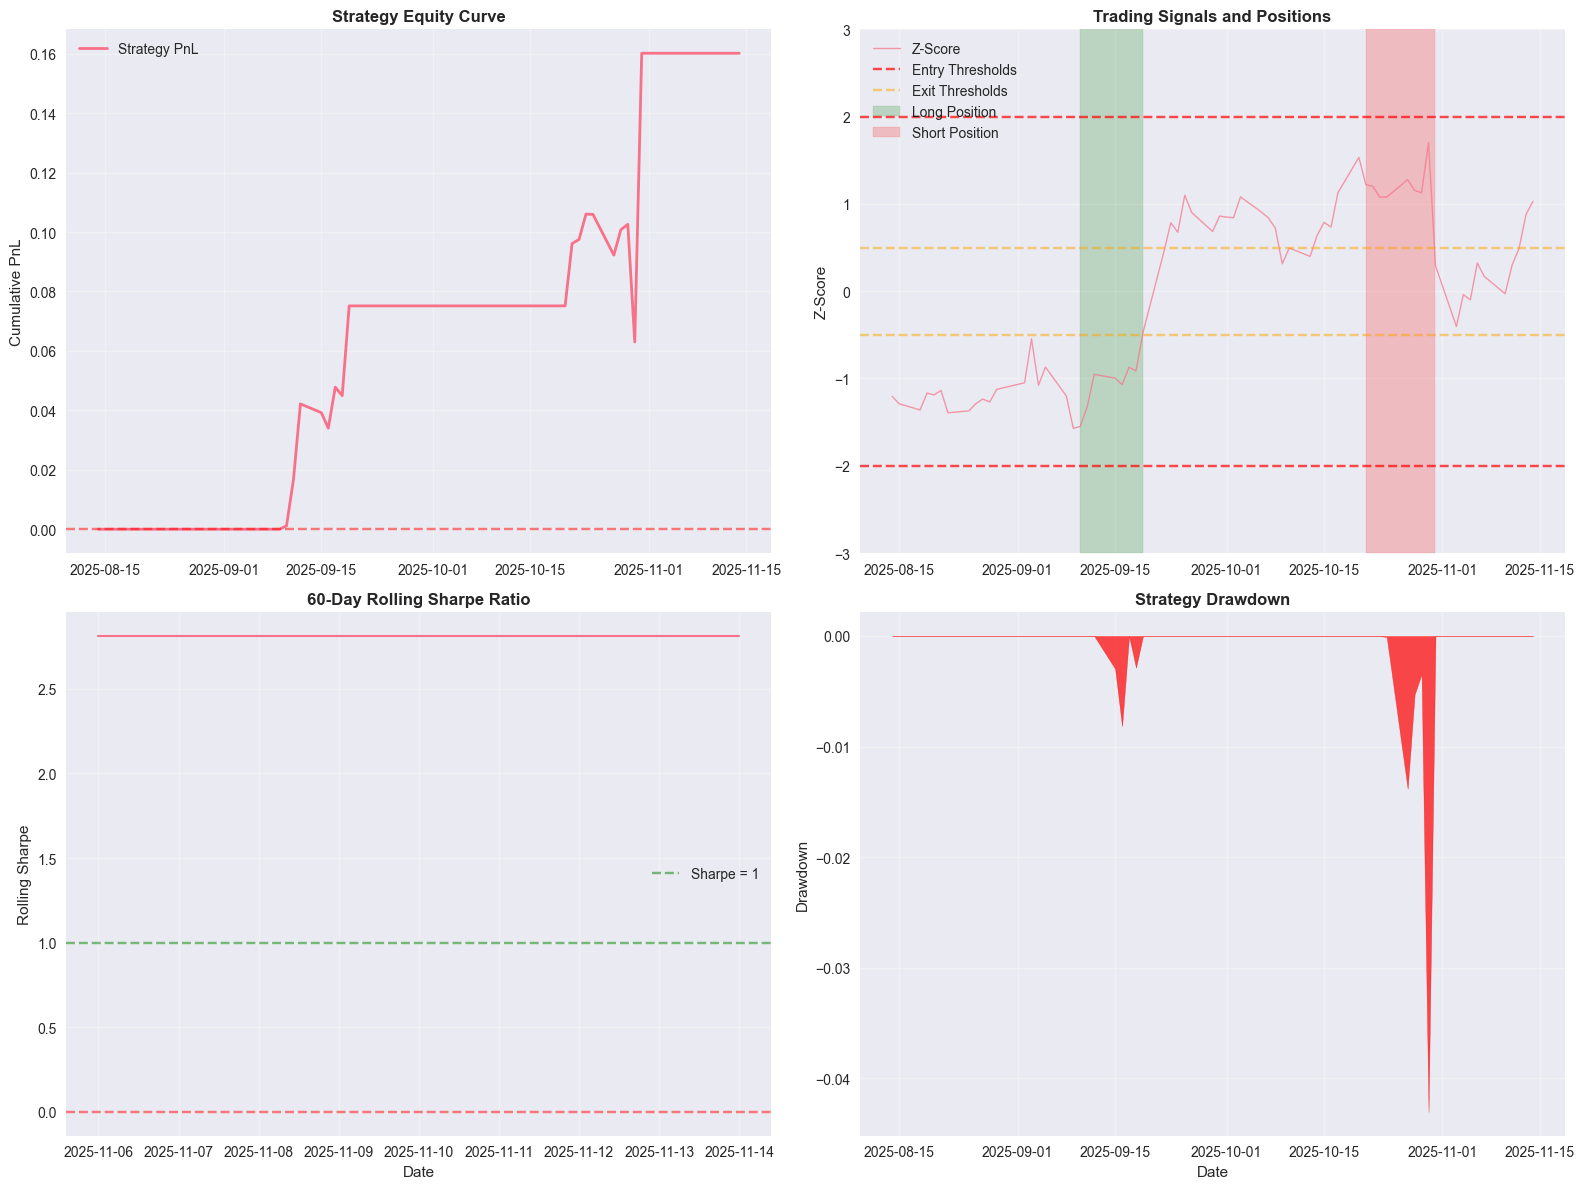


📊 Detailed Performance Analysis:

Risk Metrics:
Maximum drawdown: -0.0430 on 2025-10-30
Strategy VaR (95% on non-zero days): -0.0189
Calmar ratio: 14.211

Return Distribution:
Best day: 0.0972
Worst day: -0.0396
Positive days: 11 / 66

📅 Monthly Returns (Last 12 months):
2025-08: +0.0000
2025-09: +0.0752
2025-10: +0.0850
2025-11: +0.0000


In [31]:
# Comprehensive backtest visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Equity curve
ax1.plot(backtest_results.index, backtest_results['cumulative_pnl'],
         linewidth=2, label='Strategy PnL')
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax1.set_title('Strategy Equity Curve', fontweight='bold')
ax1.set_ylabel('Cumulative PnL')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Positions and signals
ax2.plot(backtest_results.index, backtest_results['z_score'],
         alpha=0.7, label='Z-Score', linewidth=1)
ax2.axhline(y=2, color='red', linestyle='--', alpha=0.7, label='Entry Thresholds')
ax2.axhline(y=-2, color='red', linestyle='--', alpha=0.7)
ax2.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5, label='Exit Thresholds')
ax2.axhline(y=-0.5, color='orange', linestyle='--', alpha=0.5)

# Highlight positions
long_positions = backtest_results['position'] > 0
short_positions = backtest_results['position'] < 0
ax2.fill_between(backtest_results.index, -3, 3, where=long_positions,
                alpha=0.2, color='green', label='Long Position')
ax2.fill_between(backtest_results.index, -3, 3, where=short_positions,
                alpha=0.2, color='red', label='Short Position')

ax2.set_title('Trading Signals and Positions', fontweight='bold')
ax2.set_ylabel('Z-Score')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-3, 3)

# Rolling performance
rolling_sharpe = (backtest_results['strategy_return'].rolling(60).mean() * 252) / \
                (backtest_results['strategy_return'].rolling(60).std() * np.sqrt(252))

ax3.plot(backtest_results.index, rolling_sharpe, linewidth=1.5)
ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax3.axhline(y=1, color='green', linestyle='--', alpha=0.5, label='Sharpe = 1')
ax3.set_title('60-Day Rolling Sharpe Ratio', fontweight='bold')
ax3.set_ylabel('Rolling Sharpe')
ax3.set_xlabel('Date')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Drawdown analysis
cumulative_pnl = backtest_results['cumulative_pnl']
running_max = cumulative_pnl.expanding().max()
drawdown = cumulative_pnl - running_max

ax4.fill_between(backtest_results.index, drawdown, 0, alpha=0.7, color='red')
ax4.set_title('Strategy Drawdown', fontweight='bold')
ax4.set_ylabel('Drawdown')
ax4.set_xlabel('Date')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed performance analysis
max_drawdown = drawdown.min()
max_drawdown_date = drawdown.idxmin()

print(f"\n📊 Detailed Performance Analysis:")
print(f"\nRisk Metrics:")
print(f"Maximum drawdown: {max_drawdown:.4f} on {max_drawdown_date.date()}")
if (strategy_returns != 0).any():
    print(f"Strategy VaR (95% on non-zero days): {np.percentile(strategy_returns[strategy_returns != 0], 5):.4f}")
else:
    print("Strategy VaR (95%): N/A (no non-zero returns)")
if max_drawdown != 0:
    print(f"Calmar ratio: {annual_return / abs(max_drawdown):.3f}")
else:
    print("Calmar ratio: N/A (no drawdown)")

print(f"\nReturn Distribution:")
print(f"Best day: {strategy_returns.max():.4f}")
print(f"Worst day: {strategy_returns.min():.4f}")
print(f"Positive days: {(strategy_returns > 0).sum()} / {len(strategy_returns)}")

# Monthly returns table
monthly_returns = backtest_results['strategy_return'].resample('M').sum()
print(f"\n📅 Monthly Returns (Last 12 months):")
for date, ret in monthly_returns.tail(12).items():
    print(f"{date.strftime('%Y-%m')}: {ret:+.4f}")

# 13. Why Naive Backtests Are Often Wrong
## ⚠️ Key Pitfalls & Violated Assumptions

We now step back and **critically evaluate** the whole construction.  
This is arguably the most important section of the notebook — understanding *why* backtests often look good but fail in reality.

---

### 13.1 Mean-reversion assumption

We implicitly assumed that the spread $s_t$ is **mean-reverting**:
- After large deviations (high $|Z_t|$), we expect a pullback toward the mean.
- This assumption underlies all **pairs trading** and **statistical arbitrage** logic.

However, mean reversion requires the spread to have a **stable long-term equilibrium**.  
If $s_t$ behaves like a **random walk**, it can drift arbitrarily far without reverting — breaking the entire strategy.

Mathematically, a simple mean-reverting model is the **Ornstein–Uhlenbeck (OU) process**:

$$
ds_t = \theta (\mu - s_t) \, dt + \sigma \, dW_t
$$

where:
- $\mu$ is the long-term mean,  
- $\theta$ is the *speed of reversion*,  
- $\sigma$ controls randomness.

When $\theta > 0$, deviations tend to decay back toward $\mu$.  
If $\theta = 0$, the process becomes a random walk — i.e. **non-stationary**.

---

### 13.2 Stationarity assumption

To verify whether the spread truly mean-reverts, we test **stationarity** using the **Augmented Dickey–Fuller (ADF) test**.

#### 🔹 What the ADF test does

The ADF test checks whether a time series contains a **unit root**, which indicates a **random walk**.  
It’s based on estimating:

$$
\Delta s_t = \alpha + \beta t + \gamma s_{t-1} + \sum_{i=1}^p \delta_i \Delta s_{t-i} + \varepsilon_t
$$

and testing the null hypothesis:

$$
H_0: \gamma = 0 \quad \text{(unit root → non-stationary)}
$$
$$
H_1: \gamma < 0 \quad \text{(mean-reverting → stationary)}
$$

Interpretation:
- If **p-value < 0.05** → reject $H_0$ → the series *is likely stationary* → good for mean-reversion.  
- If **p-value > 0.05** → fail to reject $H_0$ → the series *may follow a random walk*, so our z-scores are meaningless.

#### 🔹 Why this matters

If the spread is non-stationary:
- Its mean and variance **change over time**, so a fixed z-score is not valid.
- The model will see “signals” that are just **drifting noise**.
- Any apparent PnL edge is often an **artifact of trend**, not reversion.

In practice, quants also check **cointegration** (using tests like Engle–Granger or Johansen) to ensure that two price series form a stable, mean-reverting relationship.

---

### 13.3 Execution timing and gaps

- We saw that overnight **gaps** and **signal decay** are substantial.  
- Signals detected at the **Close** may vanish by the next **Open**.  
- Real traders can’t act on closing data instantly — execution delays reduce profitability.

---

### 13.4 Slippage and transaction costs

- Slippage, spreads, and commissions **compound** quickly in mean-reversion strategies.  
- Even small per-trade costs can **neutralize the statistical edge**.  
- In high-frequency setups, modeling execution costs is as important as modeling returns.

---

### 13.5 Correlation regimes and structural breaks

- Correlations between assets like AAPL and AMZN are **time-varying**.  
- Structural breaks — new product cycles, market regimes, crises — can **change relationships permanently**.  
- A once-stable pair may stop co-moving, turning a mean-reversion bet into a **directional exposure**.

---

### 13.6 Backtest overfitting

- We tuned thresholds (e.g., $\pm 1.5\sigma$, $\pm 0.5\sigma$) **on the same dataset** we evaluated on.  
- Optimizing parameters on historical data risks **fitting to noise**.  
- True validation requires **out-of-sample testing**, **walk-forward analysis**, and eventually **live trading** to verify robustness.

---

### 13.7 Takeaway

A backtest is a **mathematical experiment**, not proof of profitability.  
It tells you what *would have happened* under a **set of simplifying assumptions**.  

Your main job as a quant is to **identify and challenge those assumptions**:
- Is the spread really stationary?  
- Are the entry thresholds statistically significant?  
- Can the edge survive trading costs, latency, and changing market structure?

Only after answering these can a strategy graduate from **educational** to **realistic**.


In [33]:
# Analyze common backtest pitfalls
print("🔍 CRITICAL ANALYSIS: Why This Strategy Likely Fails\n")

# 1. Stationarity test
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series, name):
    """Test for stationarity using Augmented Dickey-Fuller test and print results."""
    result = adfuller(series.dropna())
    print(f"{name} Stationarity Test:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    if result[1] <= 0.05:
        print("✅ Stationary (p <= 0.05) - we reject the unit root hypothesis.")
    else:
        print("❌ Non-stationary (p > 0.05) - mean reversion assumption is weak.")
    print()

test_stationarity(spread_data['spread'], "Spread")
test_stationarity(spread_data['z_score'], "Z-Score")

# 2. Regime analysis
print("📊 REGIME ANALYSIS:")

# Split data into periods
n_periods = 3
period_size = len(spread_data) // n_periods

for i in range(n_periods):
    start_idx = i * period_size
    end_idx = (i + 1) * period_size if i < n_periods - 1 else len(spread_data)

    period_data = spread_data.iloc[start_idx:end_idx]
    period_corr = period_data['aapl_norm'].corr(period_data['amzn_norm'])
    period_spread_mean = period_data['spread'].mean()
    period_spread_std = period_data['spread'].std()

    print(f"Period {i+1}: {period_data.index[0].date()} to {period_data.index[-1].date()}")
    print(f"  Correlation: {period_corr:.4f}")
    print(f"  Spread mean: {period_spread_mean:.4f}")
    print(f"  Spread std: {period_spread_std:.4f}")

print("\n⚠️ MAJOR ISSUES IDENTIFIED:")

# 3. Signal decay impact
signal_decay_impact = abs(backtest_results['signal_decay']).mean()
print(f"\n1. SIGNAL DECAY:")
print(f"   Average |signal decay|: {signal_decay_impact:.4f}")
print(f"   This indicates substantial overnight changes in the spread z-score.")

# 4. Gap risk impact
gap_volatility = np.sqrt(backtest_results['aapl_gaps'].var() + backtest_results['amzn_gaps'].var())
print(f"\n2. GAP RISK:")
print(f"   Combined gap volatility (AAPL+AMZN): {gap_volatility:.4f}")
print(f"   Overnight gaps can dominate the incremental spread changes the strategy targets.")

# 5. Transaction costs
total_trades = (backtest_results['executed_trade'] != 0).sum()
trading_frequency = total_trades / len(backtest_results) * 252
print(f"\n3. TRANSACTION COSTS:")
print(f"   Trading frequency: {trading_frequency:.1f} trades/year (per unit).")
print(f"   At 0.1% cost per trade, costs can severely erode returns.")

# 6. Correlation instability
rolling_corr_std = aapl_aligned['returns'].rolling(60).corr(amzn_aligned['returns']).std()
print(f"\n4. CORRELATION INSTABILITY:")
print(f"   Std of 60-day rolling correlation: {rolling_corr_std:.4f}")
print(f"   Unstable relationships make static spread assumptions fragile.")

# 7. Overfitting risk
print(f"\n5. OVERFITTING RISK:")
print(f"   Strategy uses {len(spread_data)} data points.")
print(f"   Only {total_trades} trades executed.")
print(f"   Few trades + many choices (thresholds, windows) = high risk of overfitting.")

print(f"\n🎯 CONCLUSION:")
print(f"This strategy demonstrates why naive backtests fail:")
print(f"• Non-stationary or weakly mean-reverting relationships.")
print(f"• Execution timing issues and overnight gaps.")
print(f"• Transaction costs and slippage.")
print(f"• Time-varying correlations and regimes.")
print(f"• Overfitting to historical patterns.")
print(f"\nReal quant strategies require:")
print(f"• Robust statistical foundations (cointegration, proper tests).")
print(f"• Realistic execution modeling (latency, microstructure).")
print(f"• Out-of-sample and forward testing.")
print(f"• Rigorous risk management.")
print(f"• Continuous monitoring and adaptation to new regimes.")

🔍 CRITICAL ANALYSIS: Why This Strategy Likely Fails

Spread Stationarity Test:
ADF Statistic: -1.4097
p-value: 0.5776
❌ Non-stationary (p > 0.05) - mean reversion assumption is weak.

Z-Score Stationarity Test:
ADF Statistic: -1.4097
p-value: 0.5776
❌ Non-stationary (p > 0.05) - mean reversion assumption is weak.

📊 REGIME ANALYSIS:
Period 1: 2025-08-14 to 2025-09-15
  Correlation: 0.6193
  Spread mean: 0.0011
  Spread std: 0.0156
Period 2: 2025-09-16 to 2025-10-15
  Correlation: -0.5218
  Spread mean: 0.1144
  Spread std: 0.0454
Period 3: 2025-10-16 to 2025-11-14
  Correlation: 0.7480
  Spread mean: 0.1337
  Spread std: 0.0405

⚠️ MAJOR ISSUES IDENTIFIED:

1. SIGNAL DECAY:
   Average |signal decay|: 0.1336
   This indicates substantial overnight changes in the spread z-score.

2. GAP RISK:
   Combined gap volatility (AAPL+AMZN): 4.4275
   Overnight gaps can dominate the incremental spread changes the strategy targets.

3. TRANSACTION COSTS:
   Trading frequency: 15.3 trades/year (per 

# 14. Conclusion & Next Steps
## 🎯 Summary of What We Learned

Throughout this notebook, we walked from **raw OHLCV data** to a complete (if naive)
mean-reversion strategy, and then **critically dissected** it.

### 14.1 Mathematical tools for working with real financial data
- Construction of **log-returns** from prices.
- Computation of **sample mean**, **volatility**, **Sharpe**, and **Gaussian VaR**.
- Use of **rolling windows** for local mean and volatility.
- Analysis of **return distributions**, skewness, kurtosis, and normality tests.
- Study of **correlation** and **rolling correlation** between two assets.
- Construction of a **normalized spread** and **z-score**.
- Modeling of **execution realities**: gap risk, signal decay, slippage.
- Implementation of a **simple mean-reversion strategy** and its evaluation.

### 14.2 Key conceptual lessons
- Financial returns are **not normally distributed** → fat tails matter.
- Correlations and spreads are **time-varying** → static models are fragile.
- Execution timing and microstructure can **destroy theoretical alpha**.
- Transaction costs and slippage **compound** over many trades.
- Many attractive backtests are **artifacts of assumptions and overfitting**.

### 14.3 Next Projects
For students who want to go further:
- **Cointegration** (Engle–Granger, Johansen tests) to build statistically sound spreads.
- **More robust spread modeling** (hedge ratios, dynamic betas).
- **Transaction cost modeling** (fixed, variable, market impact).
- **Intraday data strategies** (higher frequency, more microstructure).
- **Portfolio-level risk allocation** (Kelly, risk parity, convex optimization).
- **Volatility models** (GARCH, stochastic volatility, realized vol).
- **Optimizing Sharpe under constraints** (quadratic programming, convex analysis).

**Quant finance = mathematical thinking + careful modeling + skepticism.**

This notebook was your **first real taste** of that mindset.

In [34]:
# Final comprehensive summary
print("🎓 EDUCATIONAL SUMMARY")
print("=" * 50)

print(f"\n📊 DATA PROCESSED:")
print(f"• {len(aapl_aligned)} trading days analyzed.")
print(f"• {len(common_dates)} common trading days between AAPL and AMZN.")
print(f"• Period: {common_dates[0].date()} to {common_dates[-1].date()}.")

print(f"\n📈 KEY METRICS COMPUTED:")
print(f"• Daily returns, volatility, Sharpe ratios.")
print(f"• Rolling statistics (20d, 60d windows).")
print(f"• Correlation analysis (static and rolling).")
print(f"• Value-at-Risk estimates under Gaussian assumption.")
print(f"• Distribution analysis (skewness, kurtosis, normality tests).")

print(f"\n🔧 STRATEGY COMPONENTS:")
print(f"• Spread construction and z-score normalization.")
print(f"• Entry/exit signal generation based on thresholds.")
print(f"• Execution timing and confirmation at next open.")
print(f"• Modeling of gap risk and signal decay.")
print(f"• Simple slippage and transaction cost estimation.")

print(f"\n⚠️ CRITICAL LESSONS:")
print(f"• Financial returns are NOT normally distributed (fat tails, skew).")
print(f"• Correlations and spreads are time-varying and regime-dependent.")
print(f"• Execution timing and overnight gaps can destroy theoretical signals.")
print(f"• Transaction costs and slippage quickly erode naive edges.")
print(f"• Backtests often overestimate performance and understate risk.")

print(f"\n🧮 MATHEMATICAL CONCEPTS APPLIED:")
print(f"• Log-returns and their additive properties.")
print(f"• Statistical moments (mean, variance, skew, kurtosis).")
print(f"• Rolling window calculations and annualisation.")
print(f"• Correlation, covariance, and linear relationships.")
print(f"• Z-score normalization of spreads.")
print(f"• Hypothesis testing (normality, stationarity via ADF).")

print(f"\n🎯 NEXT STEPS FOR SERIOUS QUANTS:")
print(f"1. Learn cointegration theory (Engle–Granger, Johansen tests).")
print(f"2. Study volatility modeling (GARCH, stochastic volatility, realized vol).")
print(f"3. Implement robust risk management (stop-loss, position sizing, limits).")
print(f"4. Use machine learning for richer feature engineering (carefully!).")
print(f"5. Build real-time execution systems and handle microstructure data.")
print(f"6. Study market microstructure (order books, impact, latency).")
print(f"7. Learn portfolio optimization theory and convex optimization.")

print(f"\n💡 FINAL WISDOM:")
print(f"\"In theory, there is no difference between theory and practice. In practice, there is.\"")


🎓 EDUCATIONAL SUMMARY

📊 DATA PROCESSED:
• 66 trading days analyzed.
• 66 common trading days between AAPL and AMZN.
• Period: 2025-08-14 to 2025-11-14.

📈 KEY METRICS COMPUTED:
• Daily returns, volatility, Sharpe ratios.
• Rolling statistics (20d, 60d windows).
• Correlation analysis (static and rolling).
• Value-at-Risk estimates under Gaussian assumption.
• Distribution analysis (skewness, kurtosis, normality tests).

🔧 STRATEGY COMPONENTS:
• Spread construction and z-score normalization.
• Entry/exit signal generation based on thresholds.
• Execution timing and confirmation at next open.
• Modeling of gap risk and signal decay.
• Simple slippage and transaction cost estimation.

⚠️ CRITICAL LESSONS:
• Financial returns are NOT normally distributed (fat tails, skew).
• Correlations and spreads are time-varying and regime-dependent.
• Execution timing and overnight gaps can destroy theoretical signals.
• Transaction costs and slippage quickly erode naive edges.
• Backtests often over